# Lead Scoring Case Study

__Problem Statement:__

An X Education need help to select the most promising leads, i.e. the leads that are most likely to convert into paying customers. The company requires us to build a model wherein you need to assign a lead score to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

__Goal__:

There are quite a few goals for this case study.

1. Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.

2. There are some more problems presented by the company which your model should be able to adjust to if the company's requirement changes in the future so you will need to handle these as well. These problems are provided in a separate doc file. Please fill it based on the logistic regression model you got in the first step. Also, make sure you include this in your final PPT where you'll make recommendations.

__Importing All required libraries__

In [1]:
import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, classification_report
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns",None)


#created figure function for re-usability
def figure(x,y):
    return plt.figure(figsize=[x,y])

sns.set_style("dark")

## Step-1: Data Understanding & Routine Check 

In [2]:
leads = pd.read_csv('Leads.csv')
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [3]:
leads.shape

(9240, 37)

In [4]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [5]:
#Duplicates check
leads.duplicated(subset='Prospect ID').any() #No duplicates

False

In [6]:
#Statistical description
leads.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


## Step-2: Data Cleaning & Sanity Check

In [7]:
#Based on Data Description 'Select' values in the dataframe are as good as null values, let's impute them.

leads.replace('Select', np.NaN, inplace=True)
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,NaN,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,NaN,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,NaN,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,NaN,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,NaN,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,NaN,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


__Missing Values Handeling__

In [8]:
missing_vals = pd.DataFrame(((leads.isnull().sum()/(leads.shape[0]))*100).sort_values(ascending=False))

In [9]:
missing_vals.reset_index(inplace=True)

In [10]:
missing_vals.rename(columns={'index':'Feature',0:'Missing %'},inplace=True)
missing_vals = missing_vals.iloc[0:16,:]
missing_vals

,Feature,Missing %
0,How did you hear about X Education,78.463203
1,Lead Profile,74.188312
2,Lead Quality,51.590909
3,Asymmetrique Profile Score,45.649351
4,Asymmetrique Activity Score,45.649351
5,Asymmetrique Activity Index,45.649351
6,Asymmetrique Profile Index,45.649351
7,City,39.707792
8,Specialization,36.580087
9,Tags,36.287879


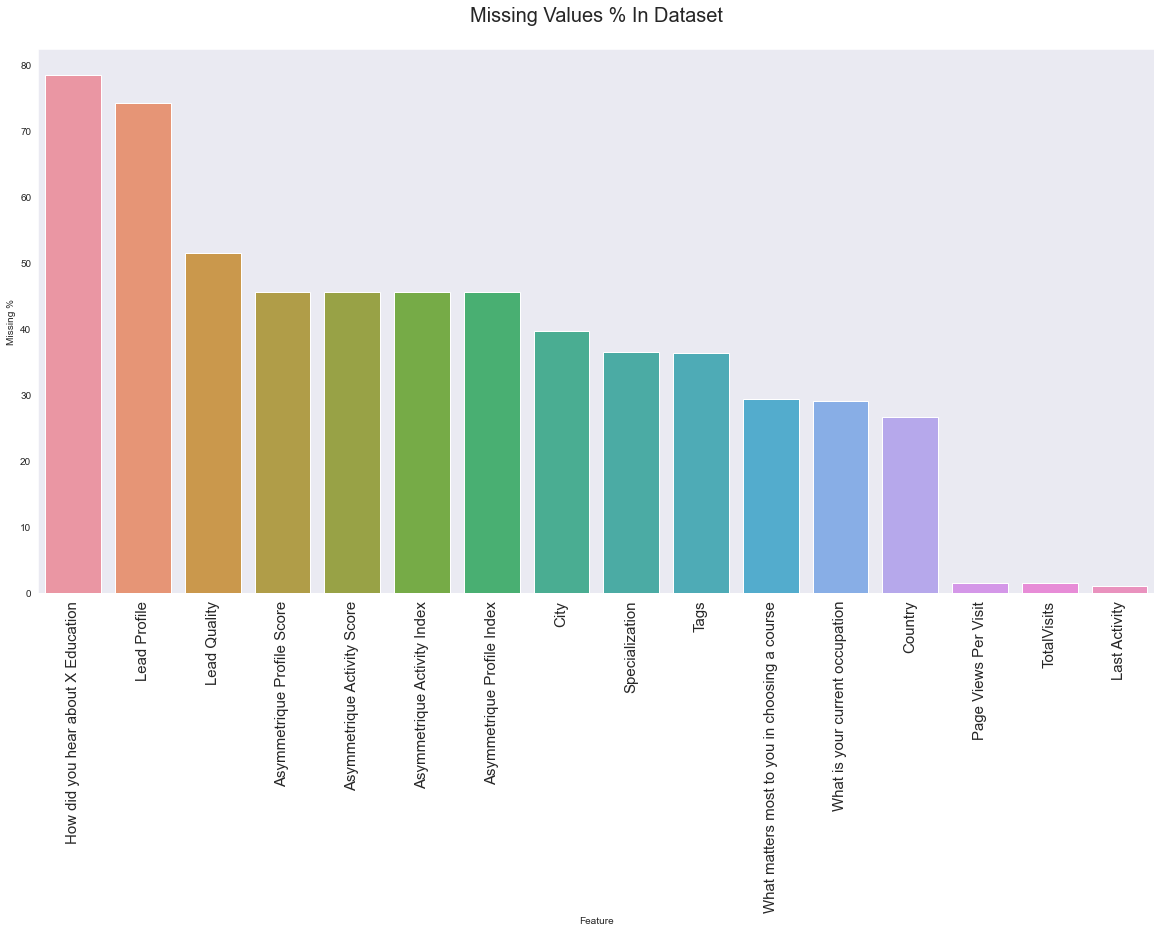

In [11]:
plt.figure(figsize=[20,10])
sns.barplot(x=missing_vals['Feature'],y=missing_vals['Missing %'])
plt.xticks(rotation=90,fontsize=15)
plt.title('Missing Values % In Dataset\n', fontdict={'size':20})

plt.show()

__Dropping Columns with Missing % > 40__

In [12]:
drop_cols = missing_vals[missing_vals['Missing %'] > 40]

drop_cols = drop_cols.Feature.values
drop_cols = list(drop_cols)
drop_cols

['How did you hear about X Education',
 'Lead Profile',
 'Lead Quality',
 'Asymmetrique Profile Score',
 'Asymmetrique Activity Score',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index']

In [13]:
leads.drop(drop_cols,inplace=True, axis=1)

In [14]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 30 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [15]:
#Columns after dropping
pd.DataFrame(((leads.isnull().sum()/(leads.shape[0]))*100).sort_values(ascending=False))

,0
City,39.707792
Specialization,36.580087
Tags,36.287879
What matters most to you in choosing a course,29.318182
What is your current occupation,29.112554
Country,26.634199
Page Views Per Visit,1.482684
TotalVisits,1.482684
Last Activity,1.114719
Lead Source,0.389610


### Imputing Rest of Missing value columns

__City__

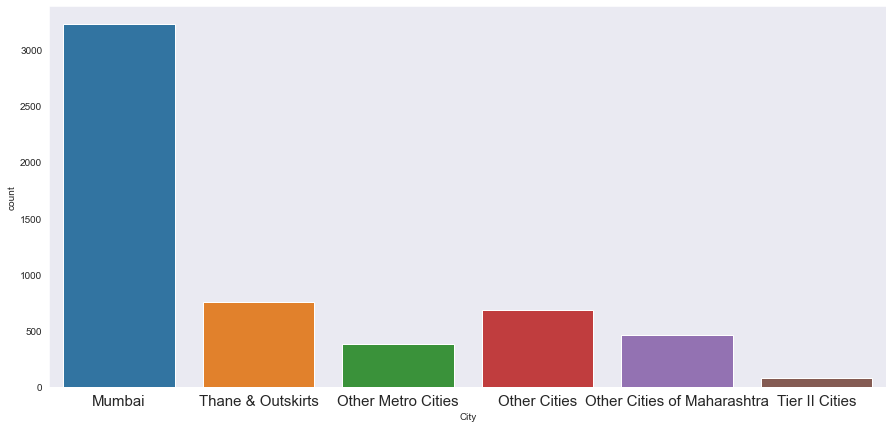

In [16]:
plt.figure(figsize=[15,7])
sns.countplot(leads.City)
plt.xticks(fontsize=15)
plt.show()


In [17]:
#Imputing Missing values & Other types of city into 'Others'
leads.City = leads.City.apply(lambda x : 'Others' if x in ['Tier II Cities','Other Metro Cities','Other Cities of Maharashtra','Other Cities',np.NaN] else x)

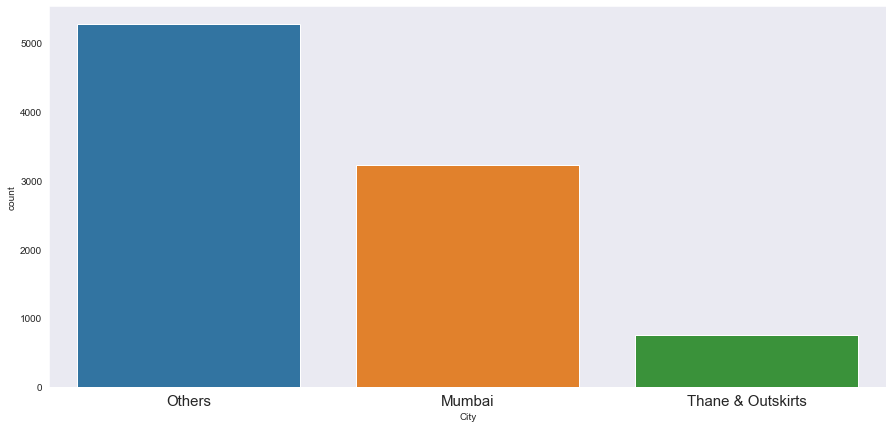

In [18]:
figure(15,7)
sns.countplot(leads.City)
plt.xticks(fontsize=15)
plt.show()

__Specialization__

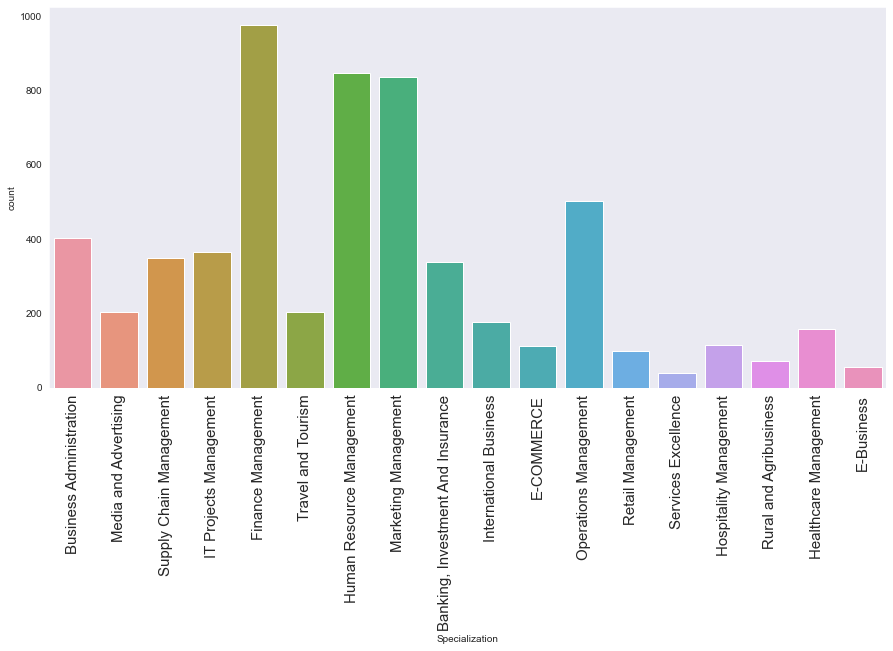

In [19]:
figure(15,7)
sns.countplot(leads.Specialization)
plt.xticks(rotation=90, fontsize=15)
plt.show()

In [20]:
# Replacing Null & ['Rural and Agribusiness','E-Business','Sevices Excellence'] to 'Others'

leads.Specialization = leads.Specialization.apply(lambda x : 'Others' if x in ['Rural and Agribusiness','E-Business','Sevices Excellence',np.NaN] else x)

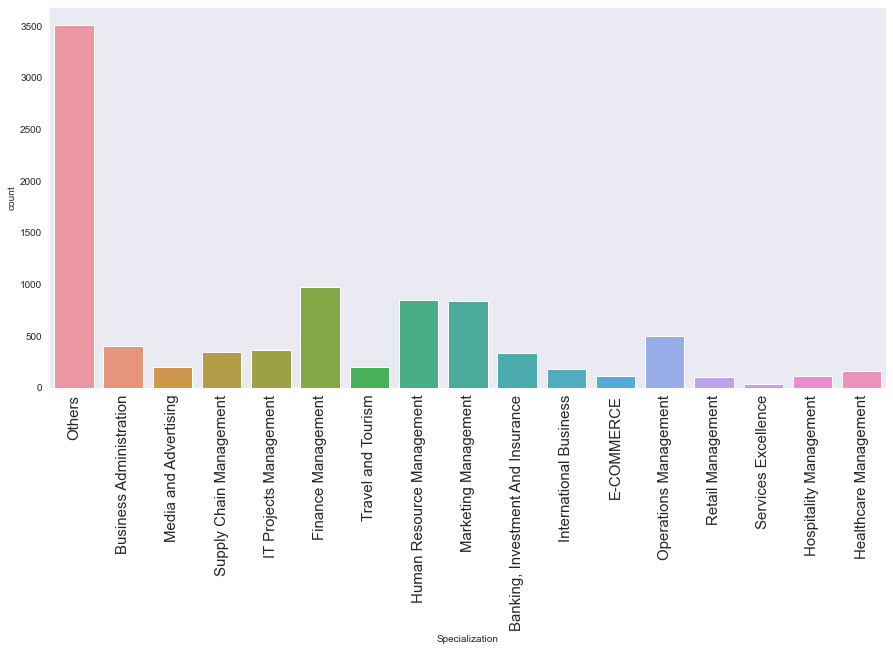

In [21]:
figure(15,7)
sns.countplot(leads.Specialization)
plt.xticks(rotation=90, fontsize=15)
plt.show()

__Tags__

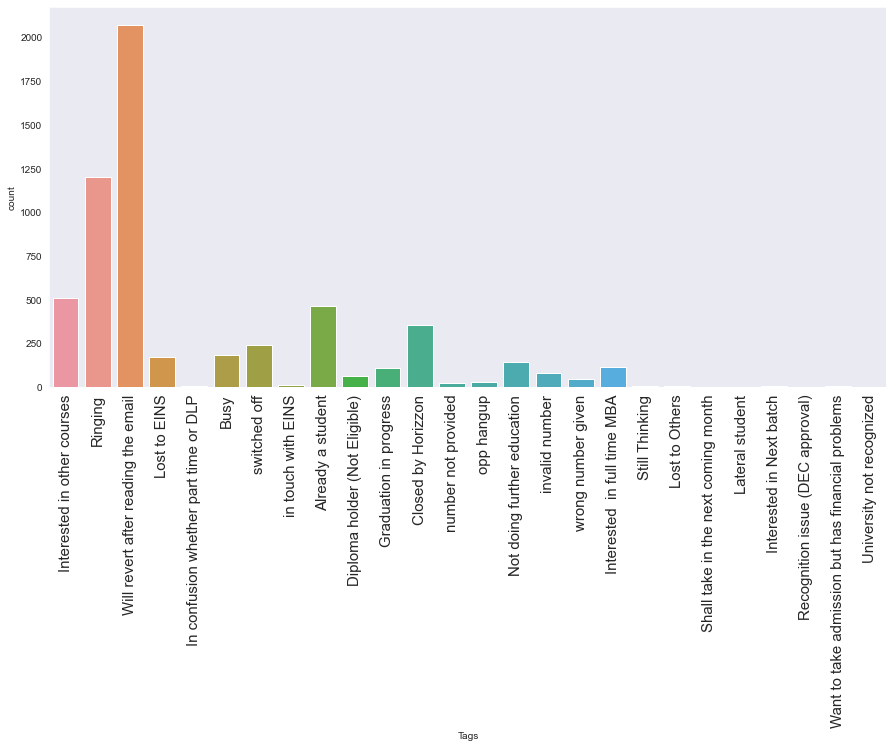

In [22]:
figure(15,7)
sns.countplot(leads.Tags)
plt.xticks(rotation=90, fontsize=15)
plt.show()

In [23]:
# Replacing to 'Others'

leads.Tags = leads.Tags.apply(lambda x : 'Others' if x in ['switched off', 'Busy', 'Lost to EINS', 'Not doing further education', 'Interested  in full time MBA',
                                     'Graduation in progress', 'invalid number', 'Diploma holder (Not Eligible)', 'wrong number given', 'opp hangup','Closed by Horizzon',
                                     'Shall take in the next coming month', 'University not recognized', 'Recognition issue (DEC approval)',                                                           'number not provided', 'in touch with EINS', 'Lost to Others', 'Want to take admission but has financial problems',
                                     'Still Thinking', 'Interested in Next batch', 'In confusion whether part time or DLP', 'Lateral student',
                                     np.NaN
                                     ] else x)

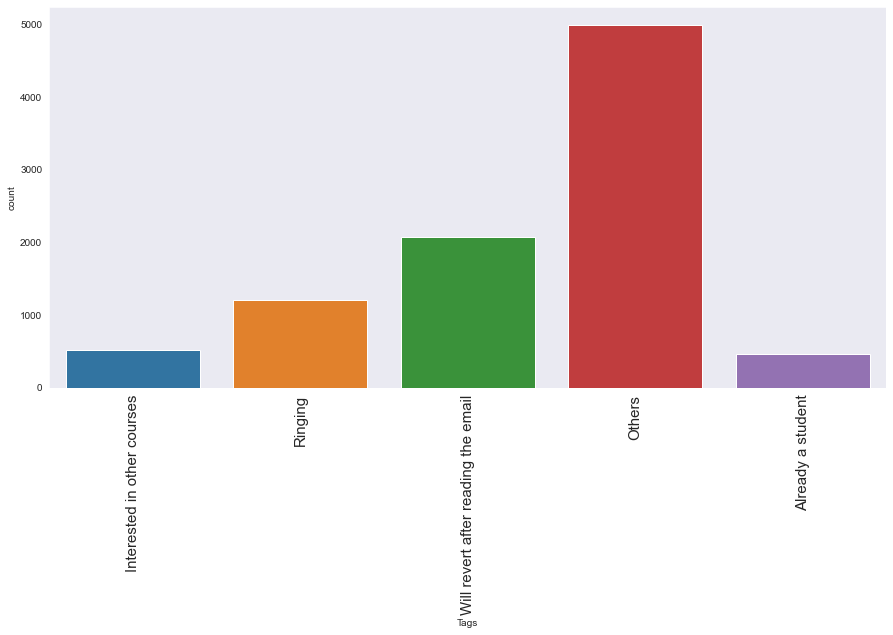

In [24]:
figure(15,7)
sns.countplot(leads.Tags)
plt.xticks(rotation=90, fontsize=15)
plt.show()

__What matters most to you in choosing a course__

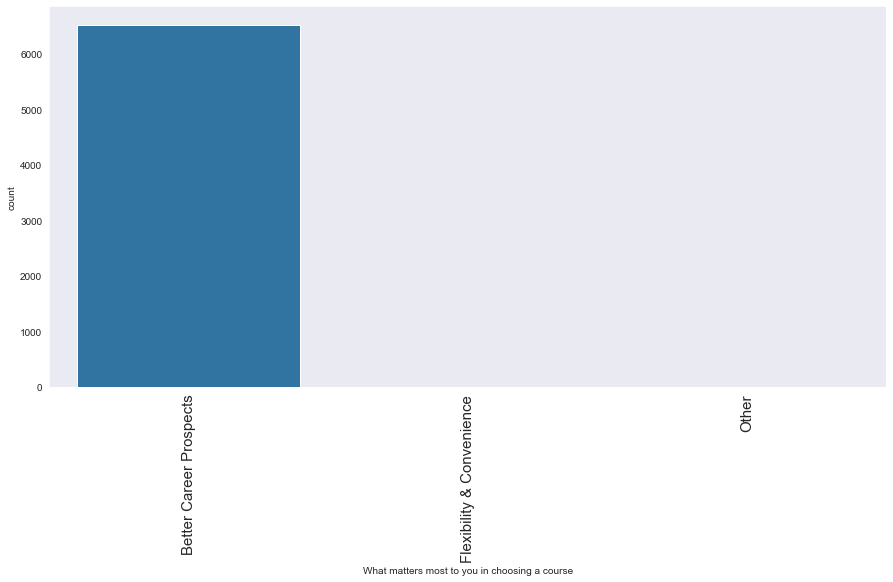

In [25]:
figure(15,7)
sns.countplot(leads['What matters most to you in choosing a course'])
plt.xticks(rotation=90, fontsize=15)
plt.show()

'Better Career Prospects' has the only values, it's better to drop this column as it is of no use.

In [26]:
leads.drop(columns='What matters most to you in choosing a course', inplace=True)
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 29 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Prospect ID                               9240 non-null   object 
 1   Lead Number                               9240 non-null   int64  
 2   Lead Origin                               9240 non-null   object 
 3   Lead Source                               9204 non-null   object 
 4   Do Not Email                              9240 non-null   object 
 5   Do Not Call                               9240 non-null   object 
 6   Converted                                 9240 non-null   int64  
 7   TotalVisits                               9103 non-null   float64
 8   Total Time Spent on Website               9240 non-null   int64  
 9   Page Views Per Visit                      9103 non-null   float64
 10  Last Activity                       

__What is your current occupation__

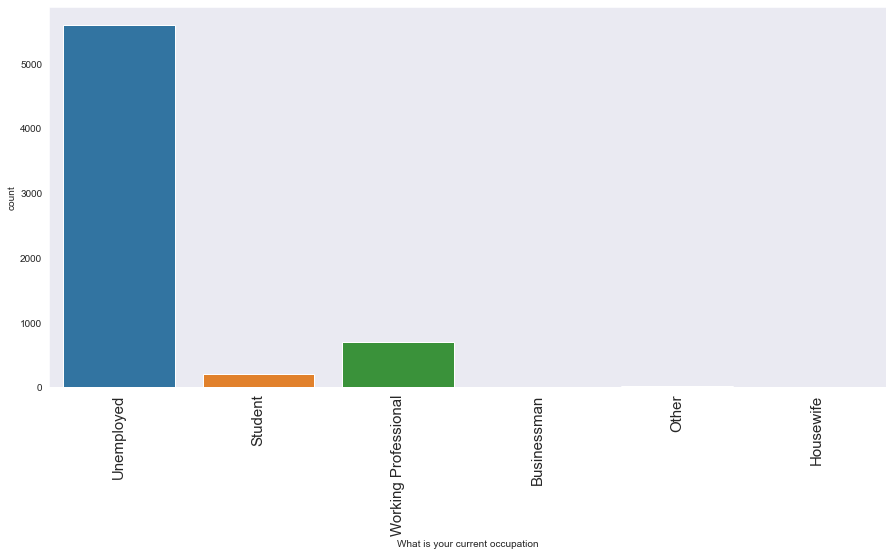

In [27]:
figure(15,7)
sns.countplot(leads['What is your current occupation'])
plt.xticks(rotation=90, fontsize=15)
plt.show()

In [28]:
leads['What is your current occupation'] = leads['What is your current occupation'].replace(np.NaN,'Other')

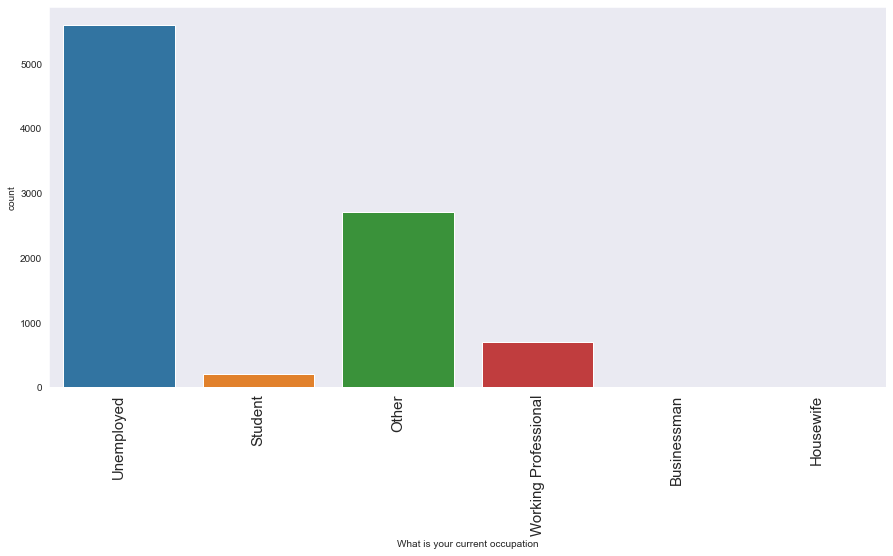

In [29]:
figure(15,7)
sns.countplot(leads['What is your current occupation'])
plt.xticks(rotation=90, fontsize=15)
plt.show()

__Country__

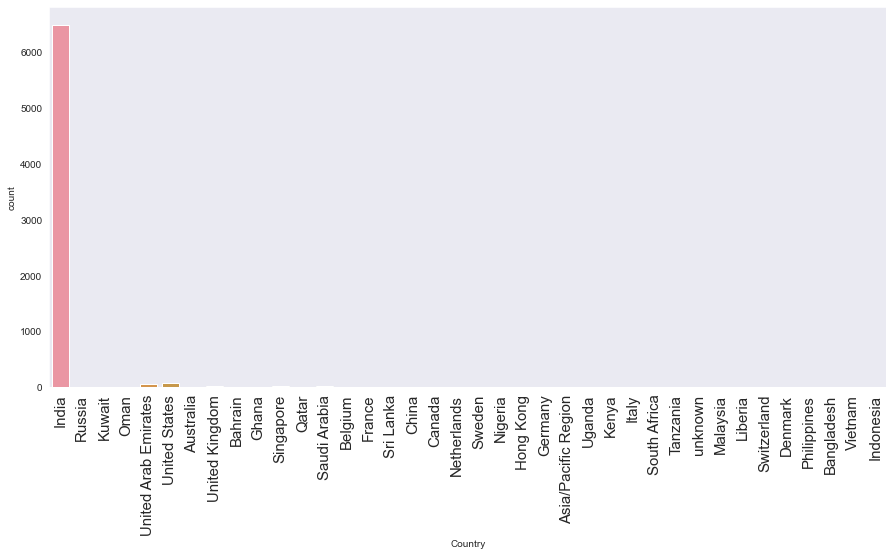

In [30]:
figure(15,7)
sns.countplot(leads.Country)
plt.xticks(rotation=90, fontsize=15)
plt.show()

In [31]:
#Dropping Country as looks not useful, data is very much imbalanced and skewed

leads.drop(columns=['Country'], inplace=True)
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 28 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Prospect ID                               9240 non-null   object 
 1   Lead Number                               9240 non-null   int64  
 2   Lead Origin                               9240 non-null   object 
 3   Lead Source                               9204 non-null   object 
 4   Do Not Email                              9240 non-null   object 
 5   Do Not Call                               9240 non-null   object 
 6   Converted                                 9240 non-null   int64  
 7   TotalVisits                               9103 non-null   float64
 8   Total Time Spent on Website               9240 non-null   int64  
 9   Page Views Per Visit                      9103 non-null   float64
 10  Last Activity                       

__Page Views Per Visit__

In [32]:
# Since this is a numeric column and not a categorical column, lets impute the missing values with statistical parameter
leads['Page Views Per Visit'].describe()

count    9103.000000
mean        2.362820
std         2.161418
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64

In [33]:
leads['Page Views Per Visit'].fillna(leads['Page Views Per Visit'].median(), inplace=True)

__TotalVisits__

In [34]:
# Since this is a numeric column and not a categorical column, lets impute the missing values with statistical parameter
leads['TotalVisits'].describe()

count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64

In [35]:
leads['TotalVisits'].fillna(leads['TotalVisits'].median(), inplace=True)

__Last Activity__

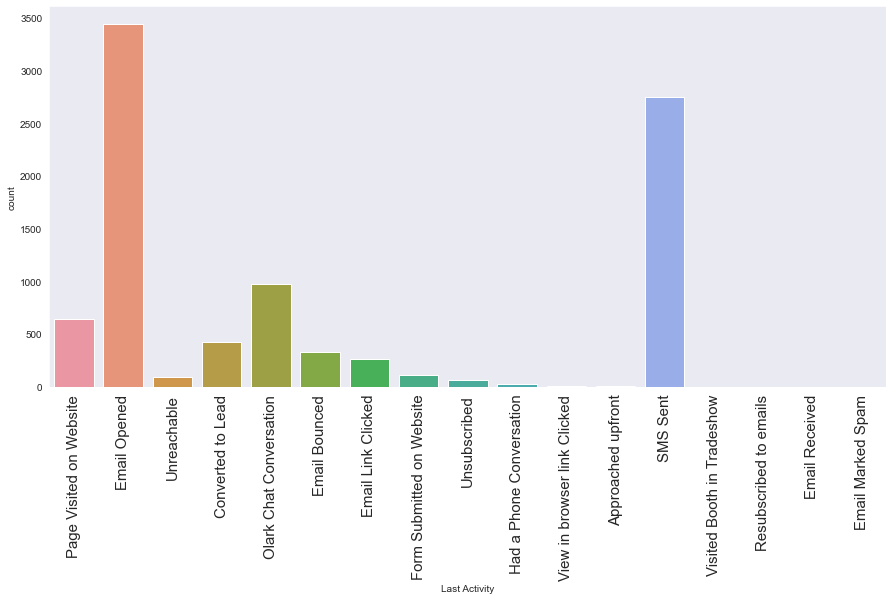

In [36]:
figure(15,7)
sns.countplot(leads['Last Activity'])
plt.xticks(rotation=90, fontsize=15)
plt.show()

In [37]:
#Imputing to 'Others'

leads['Last Activity'] = leads['Last Activity'].apply(lambda x : 'Others' if x in ['Email Received','Email Marked Spam','Unreachable','Unsubscribed',
                                                                                 'Visited Booth in Tradeshow','Had a Phone Conversation','Approached upfront',
                                                                                 'View in browser link Clicked','Resubscribed to emails',np.NaN]
                                                                                 else x)

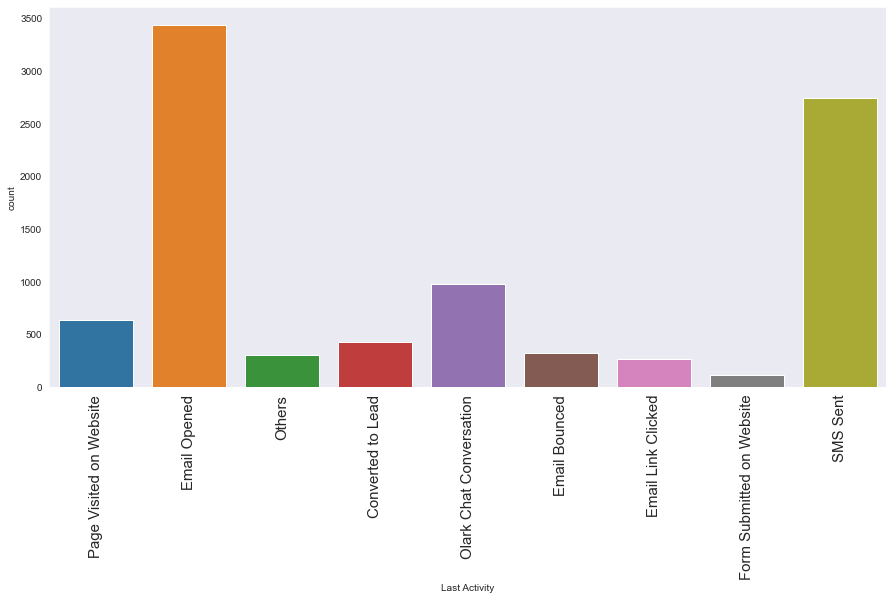

In [38]:
figure(15,7)
sns.countplot(leads['Last Activity'])
plt.xticks(rotation=90, fontsize=15)
plt.show()

__Lead Source__

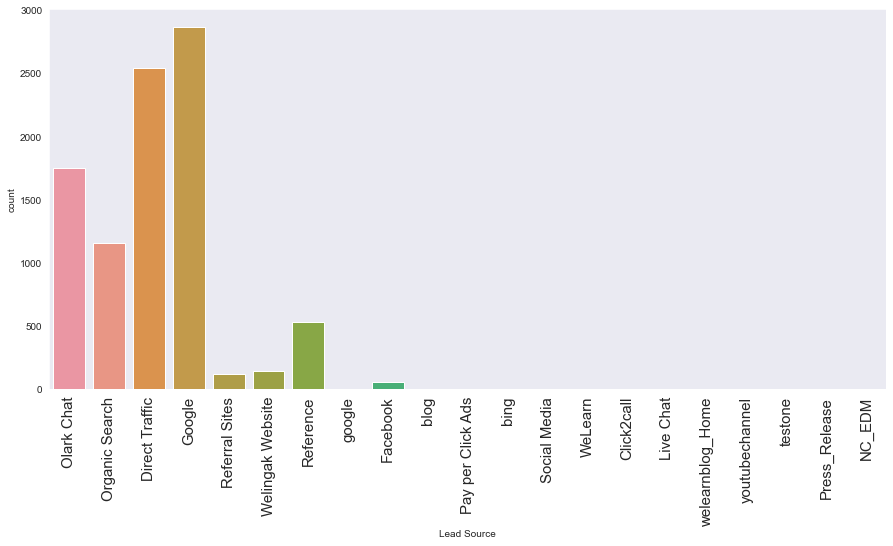

In [39]:
figure(15,7)
sns.countplot(leads['Lead Source'])
plt.xticks(rotation=90, fontsize=15)
plt.show()

In [40]:
# There are 2 Google categorys, Let's merge it to one
leads['Lead Source'] = leads['Lead Source'].replace('google','Google')

#Imputing to 'Others'
leads['Lead Source'] = leads['Lead Source'].apply(lambda x: 'Others' if x in ['bing', 'Click2call', 'Press_Release',
                                                   'testone', 'NC_EDM', 'Live Chat', 'Facebook', 'Social Media'                            
                                                   'WeLearn', 'blog', 'Pay per Click Ads',
                                                    'youtubechannel', 'welearnblog_Home',np.NaN                          
                                                   ] else x)

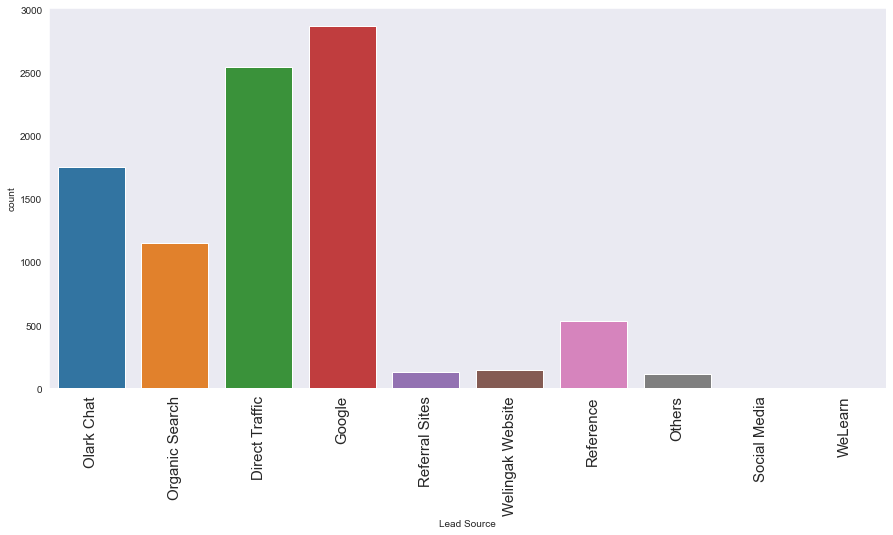

In [41]:
figure(15,7)
sns.countplot(leads['Lead Source'])
plt.xticks(rotation=90, fontsize=15)
plt.show()

__Last Notable Activity__

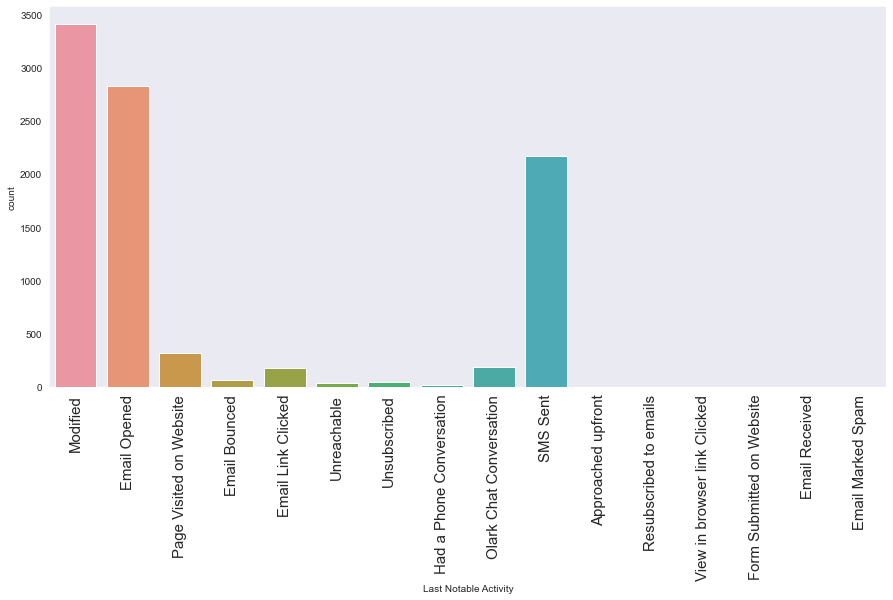

In [42]:
figure(15,7)
sns.countplot(leads['Last Notable Activity'])
plt.xticks(rotation=90, fontsize=15)
plt.show()

In [43]:
#Imputing to Others
leads['Last Notable Activity'] = leads['Last Notable Activity'].apply(lambda x: 'Others' if x in ['Approached upfront',
                                  'Unreachable','Unsubscribed','Had a Phone Conversation','Email Bounced','Resubscribed to emails'
                                  ,'View in browser link Clicked','Form Submitted on Website','Email Received','Email Marked Spam']
                                    else x)

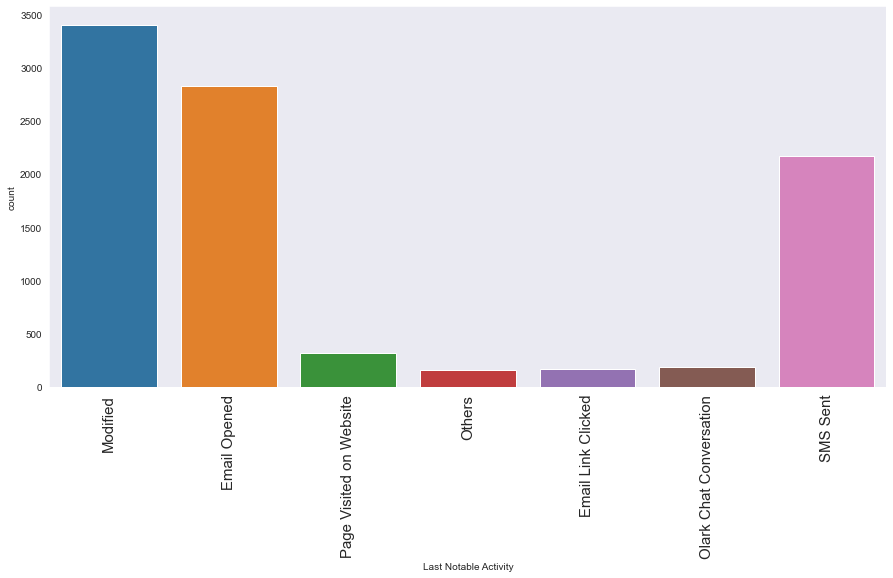

In [44]:
figure(15,7)
sns.countplot(leads['Last Notable Activity'])
plt.xticks(rotation=90, fontsize=15)
plt.show()

### After dealing with all the columns with majority of missing values:

In [45]:
pd.DataFrame(((leads.isnull().sum()/(leads.shape[0]))*100).sort_values(ascending=False))

,0
Prospect ID,0.0
Lead Number,0.0
A free copy of Mastering The Interview,0.0
I agree to pay the amount through cheque,0.0
City,0.0
Get updates on DM Content,0.0
Update me on Supply Chain Content,0.0
Tags,0.0
Receive More Updates About Our Courses,0.0
Through Recommendations,0.0


In [46]:
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,Others,Unemployed,No,No,No,No,No,No,No,No,Interested in other courses,No,No,Others,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,Others,Unemployed,No,No,No,No,No,No,No,No,Ringing,No,No,Others,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,Business Administration,Student,No,No,No,No,No,No,No,No,Will revert after reading the email,No,No,Mumbai,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Others,Media and Advertising,Unemployed,No,No,No,No,No,No,No,No,Ringing,No,No,Mumbai,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,Others,Unemployed,No,No,No,No,No,No,No,No,Will revert after reading the email,No,No,Mumbai,No,No,Modified


In [47]:
# Dropping 'Prospect ID' & 'Lead Number' as they are of no use for analysis
xleads = leads.drop(columns=['Prospect ID', 'Lead Number'])
xleads.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,Others,Unemployed,No,No,No,No,No,No,No,No,Interested in other courses,No,No,Others,No,No,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,Others,Unemployed,No,No,No,No,No,No,No,No,Ringing,No,No,Others,No,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,Business Administration,Student,No,No,No,No,No,No,No,No,Will revert after reading the email,No,No,Mumbai,No,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Others,Media and Advertising,Unemployed,No,No,No,No,No,No,No,No,Ringing,No,No,Mumbai,No,No,Modified
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,Others,Unemployed,No,No,No,No,No,No,No,No,Will revert after reading the email,No,No,Mumbai,No,No,Modified


### Outlier Handeling:

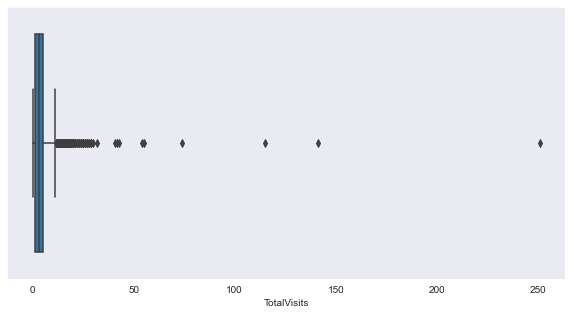

In [48]:
# Inspecting "TotalVisits"

figure(10,5)
sns.boxplot(xleads['TotalVisits'])
plt.show()

In [49]:
xleads.TotalVisits.describe(percentiles=[0.10,0.25,0.5,0.75,0.99])

count    9240.000000
mean        3.438636
std         4.819024
min         0.000000
10%         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
99%        17.000000
max       251.000000
Name: TotalVisits, dtype: float64

Looks like there are some outliers in total visits, lets remove top and bottom 1% of data 

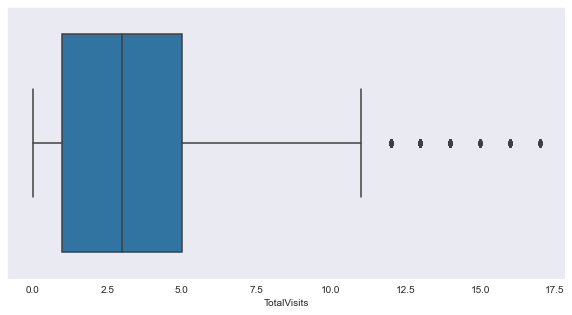

In [50]:
Q3 = xleads.TotalVisits.quantile(0.99)
xleads = xleads[xleads.TotalVisits <= Q3]
Q1 = xleads.TotalVisits.quantile(0.01)
xleads = xleads[xleads.TotalVisits >= Q1]

figure(10,5)
sns.boxplot(xleads['TotalVisits'])
plt.show()

In [51]:
# Inspecting "Total Time Spent on Website"

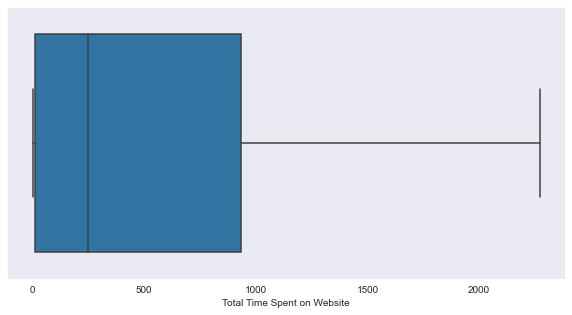

In [52]:
figure(10,5)
sns.boxplot(xleads['Total Time Spent on Website'])
plt.show()

This looks clean!.

In [53]:
# Inspecting "Page Views Per Visit"

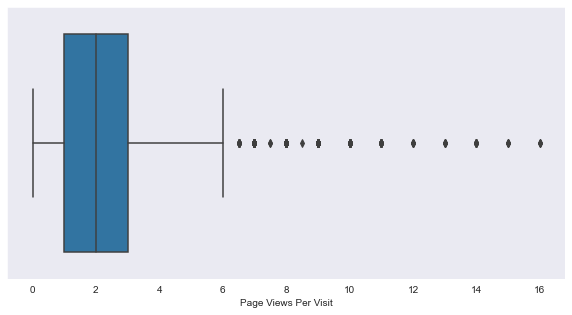

In [54]:
figure(10,5)
sns.boxplot(xleads['Page Views Per Visit'])
plt.show()

In [55]:
xleads['Page Views Per Visit'].describe(percentiles=[0.10,0.25,0.5,0.75,0.99])

count    9157.000000
mean        2.332225
std         2.047285
min         0.000000
10%         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
99%         9.000000
max        16.000000
Name: Page Views Per Visit, dtype: float64

There are outliers existing above the upper whisker , lets remove them.

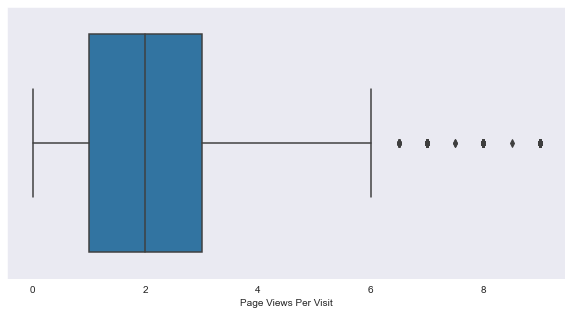

In [56]:
Q3 = xleads['Page Views Per Visit'].quantile(0.99)
xleads = xleads[xleads['Page Views Per Visit'] <= Q3]


figure(10,5)
sns.boxplot(xleads['Page Views Per Visit'])
plt.show()

In [57]:
xleads['Page Views Per Visit'].describe(percentiles=[0.10,0.25,0.5,0.75,0.99])

count    9090.000000
mean        2.262836
std         1.881164
min         0.000000
10%         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
99%         8.000000
max         9.000000
Name: Page Views Per Visit, dtype: float64

## Step-3: Exploratory Data Analysis(EDA)

In [58]:
#Dividing Categorical & Numeric columns for analysis
cols = xleads.columns.to_list()
num_cols = ['Converted','TotalVisits','Total Time Spent on Website','Page Views Per Visit']
cat_cols = [i for i in cols if i not in num_cols]

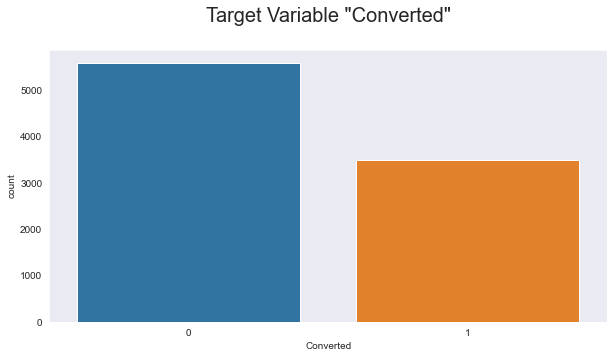

In [59]:
#Inspecting Target variable 'Converted'
figure(10,5)
sns.countplot(xleads.Converted)
plt.title('Target Variable "Converted"\n', fontdict={'size':20})
plt.show()

In [60]:
sum(xleads.Converted)/len(xleads.Converted)*100

38.448844884488445

__Approximately 38.5% leads were converted__

### Univaraite Analysis : Categorical Variables

_____________________________________________________________________________________________________________________


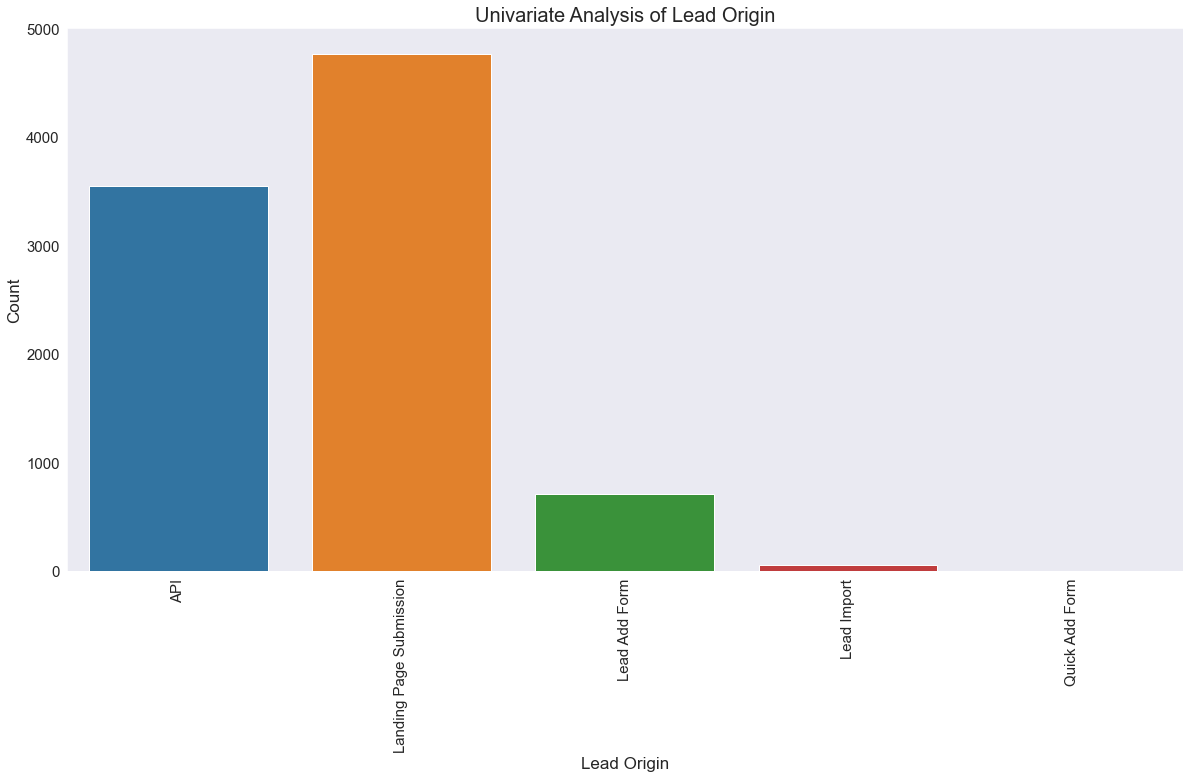

_____________________________________________________________________________________________________________________


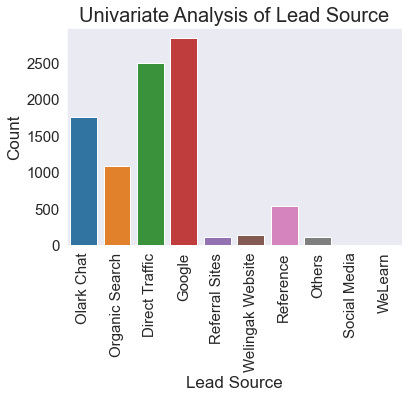

_____________________________________________________________________________________________________________________


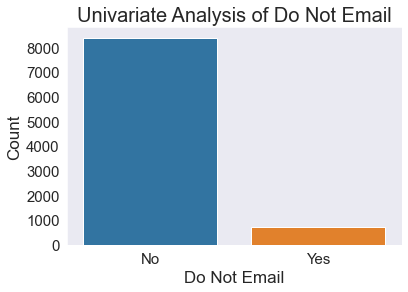

_____________________________________________________________________________________________________________________


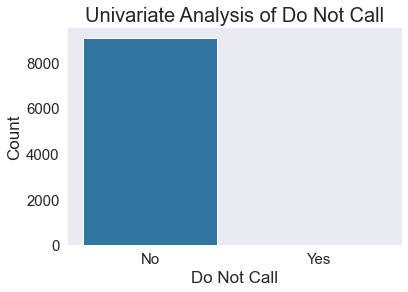

_____________________________________________________________________________________________________________________


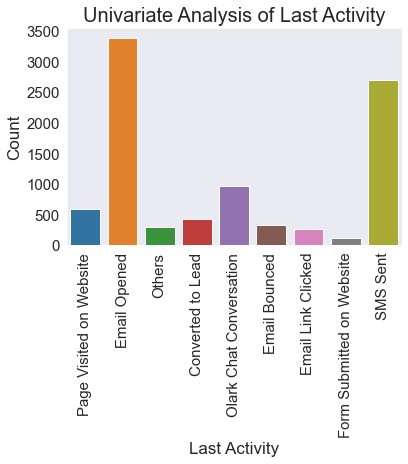

_____________________________________________________________________________________________________________________


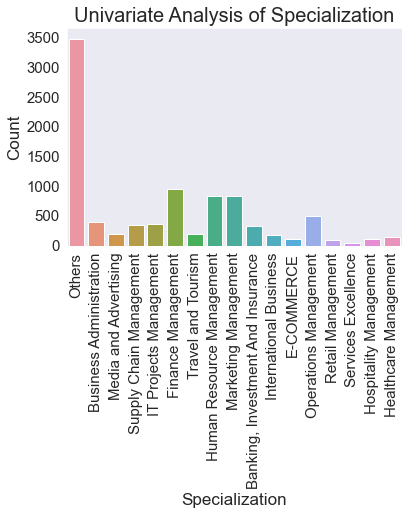

_____________________________________________________________________________________________________________________


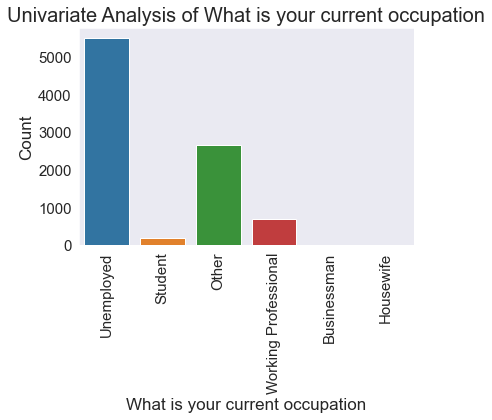

_____________________________________________________________________________________________________________________


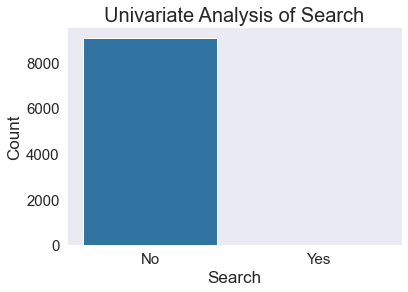

_____________________________________________________________________________________________________________________


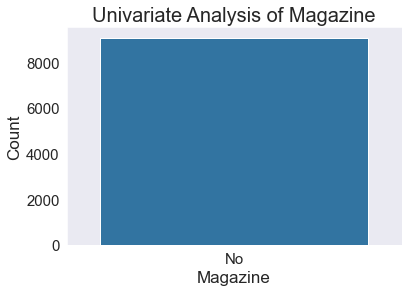

_____________________________________________________________________________________________________________________


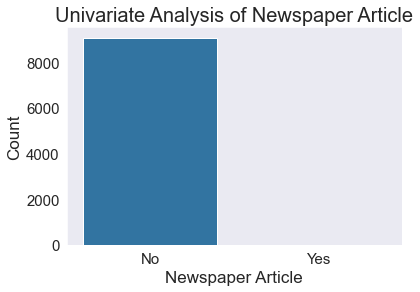

_____________________________________________________________________________________________________________________


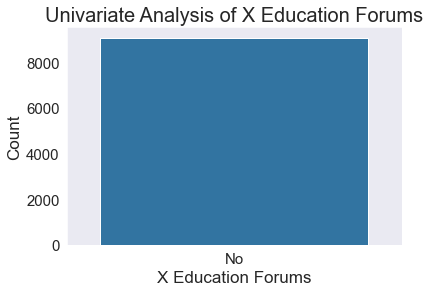

_____________________________________________________________________________________________________________________


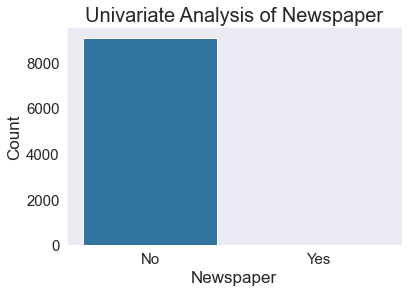

_____________________________________________________________________________________________________________________


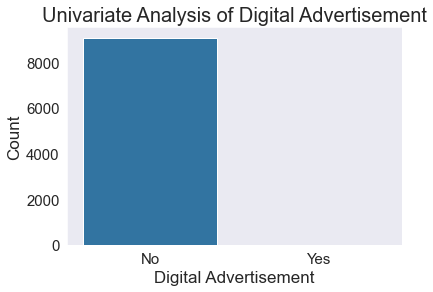

_____________________________________________________________________________________________________________________


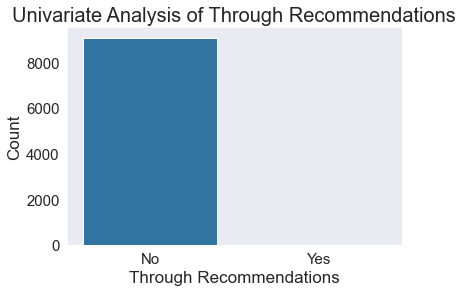

_____________________________________________________________________________________________________________________


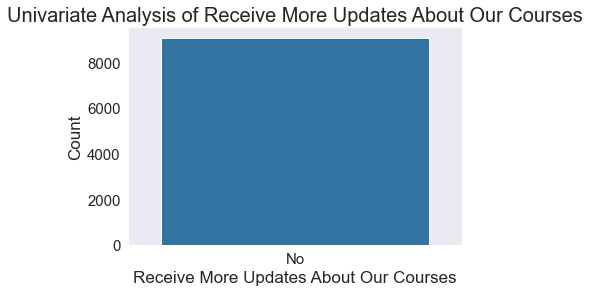

_____________________________________________________________________________________________________________________


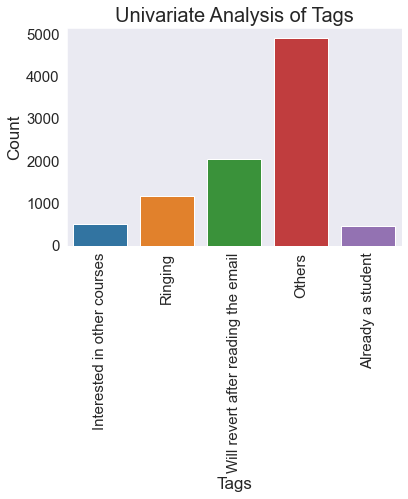

_____________________________________________________________________________________________________________________


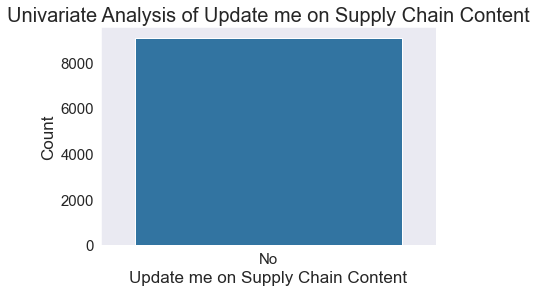

_____________________________________________________________________________________________________________________


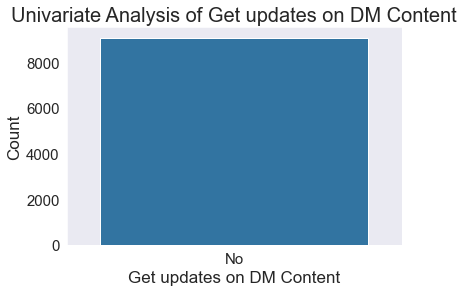

_____________________________________________________________________________________________________________________


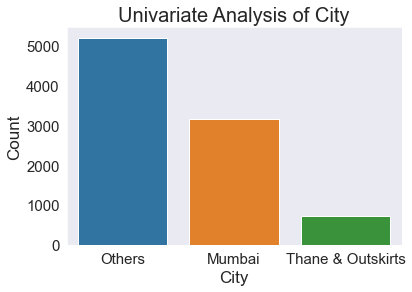

_____________________________________________________________________________________________________________________


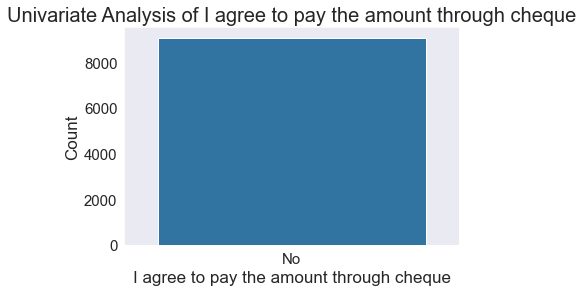

_____________________________________________________________________________________________________________________


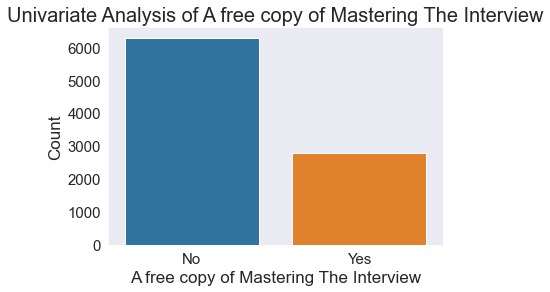

_____________________________________________________________________________________________________________________


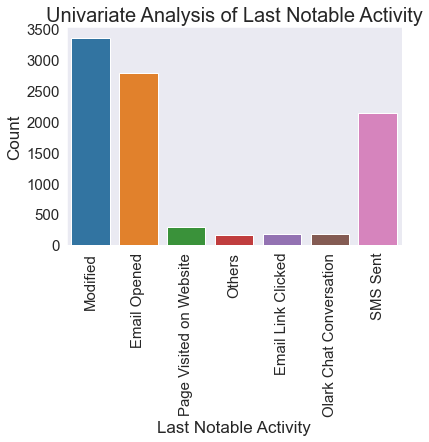

In [61]:
figure(20,10)

i=1
for i in cat_cols:
    sns.countplot(xleads[i])
    plt.title(f'Univariate Analysis of {i}', fontdict={'size':20})
    if len(xleads[i].value_counts()) > 4:
        plt.xticks(rotation=90, size=15)
    else:
        plt.xticks(rotation=0, size=15)
    
    plt.yticks(size=15)
    plt.xlabel(i,size=17)
    plt.ylabel('Count',size=17)
    print('_____________________________________________________________________________________________________________________')
    plt.show()
    
    

### From the above we could see that many columns are imblanace where majority of the values are "No" and less vlaues as "Yes", Let's remove them

In [62]:
imbalanced_cols = ['Search','Do Not Call','Magazine','Newspaper Article','X Education Forums','Newspaper','Digital Advertisement',
                  'Through Recommendations','Receive More Updates About Our Courses', 'Update me on Supply Chain Content'
                  ,'Get updates on DM Content','I agree to pay the amount through cheque']

xleads.drop(columns=imbalanced_cols,inplace=True)



In [63]:
cat_cols = [i for i in cat_cols if i not in imbalanced_cols]
cat_cols

['Lead Origin',
 'Lead Source',
 'Do Not Email',
 'Last Activity',
 'Specialization',
 'What is your current occupation',
 'Tags',
 'City',
 'A free copy of Mastering The Interview',
 'Last Notable Activity']

### Univaraite Analysis : Numeric Variables

_____________________________________________________________________________________________________________________


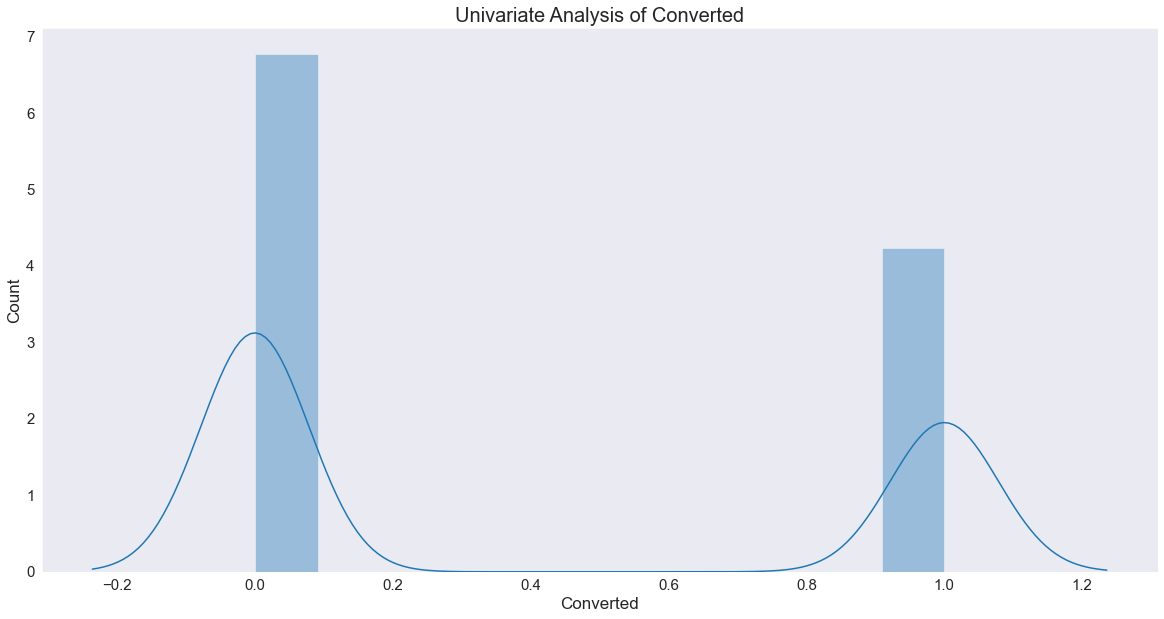

_____________________________________________________________________________________________________________________


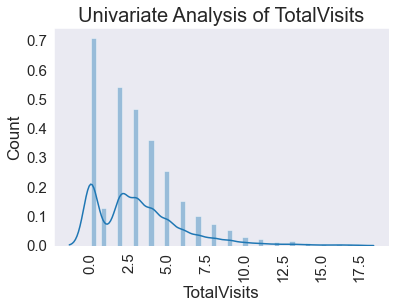

_____________________________________________________________________________________________________________________


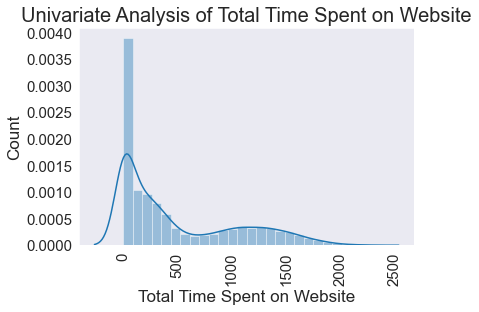

_____________________________________________________________________________________________________________________


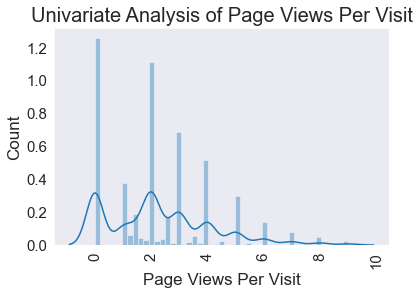

In [64]:
figure(20,10)

i=1
for i in num_cols:
    sns.distplot(xleads[i])
    plt.title(f'Univariate Analysis of {i}', fontdict={'size':20})
    if len(xleads[i].value_counts()) > 4:
        plt.xticks(rotation=90, size=15)
    else:
        plt.xticks(rotation=0, size=15)
    
    plt.yticks(size=15)
    plt.xlabel(i,size=17)
    plt.ylabel('Count',size=17)
    print('_____________________________________________________________________________________________________________________')
    plt.show()
    

### Bivariate Analysis : Target Variable Vs All variables

In [65]:
figure(20,10)

#Dividing the dataset into 2  parts(1-Converted,0-Not Converted)
target0 = xleads[xleads.Converted == 0]
target1 = xleads[xleads.Converted == 1]


def unis(t0var,t1var,dimensions=[20,10],font=20,tfont=20,rotx=None,size=15):
    
    sns.set_theme(style='darkgrid')
    sns.set_palette("Set2")
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    #target-0
    plt.figure(figsize=dimensions)
    plt.subplot(1,2,1)
    plt.title('0 - Not Converted\n', fontdict={'fontsize':tfont})
    splot=sns.countplot(x=t0var)
    for p in splot.patches:
        splot.annotate(p.get_height(),#text that you want to write on top
        (p.get_x() + p.get_width() / 2., p.get_height()),# coordinates where text should be there
        ha = 'center', va = 'center',size=size,# alignment of the text
        xytext = (0, 10),# distance of text from top of the patch
        textcoords = 'offset points'), #do not change and remove it
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.xticks(rotation=rotx)
    
    #target-1
    plt.subplot(1,2,2)
    plt.title('1 - Converted\n', fontdict={'fontsize': tfont})
    gplot=sns.countplot(x=t1var)
    for p in gplot.patches:
        gplot.annotate(p.get_height(),#text that you want to write on top
        (p.get_x() + p.get_width() / 2., p.get_height()),# coordinates where text should be there
        ha = 'center', va = 'center',size=size,# alignment of the text
        xytext = (0, 10),# distance of text from top of the patch
        textcoords = 'offset points'), #do not change and remove it
           
        
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.xticks(rotation=rotx)
    
    

<Figure size 1440x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

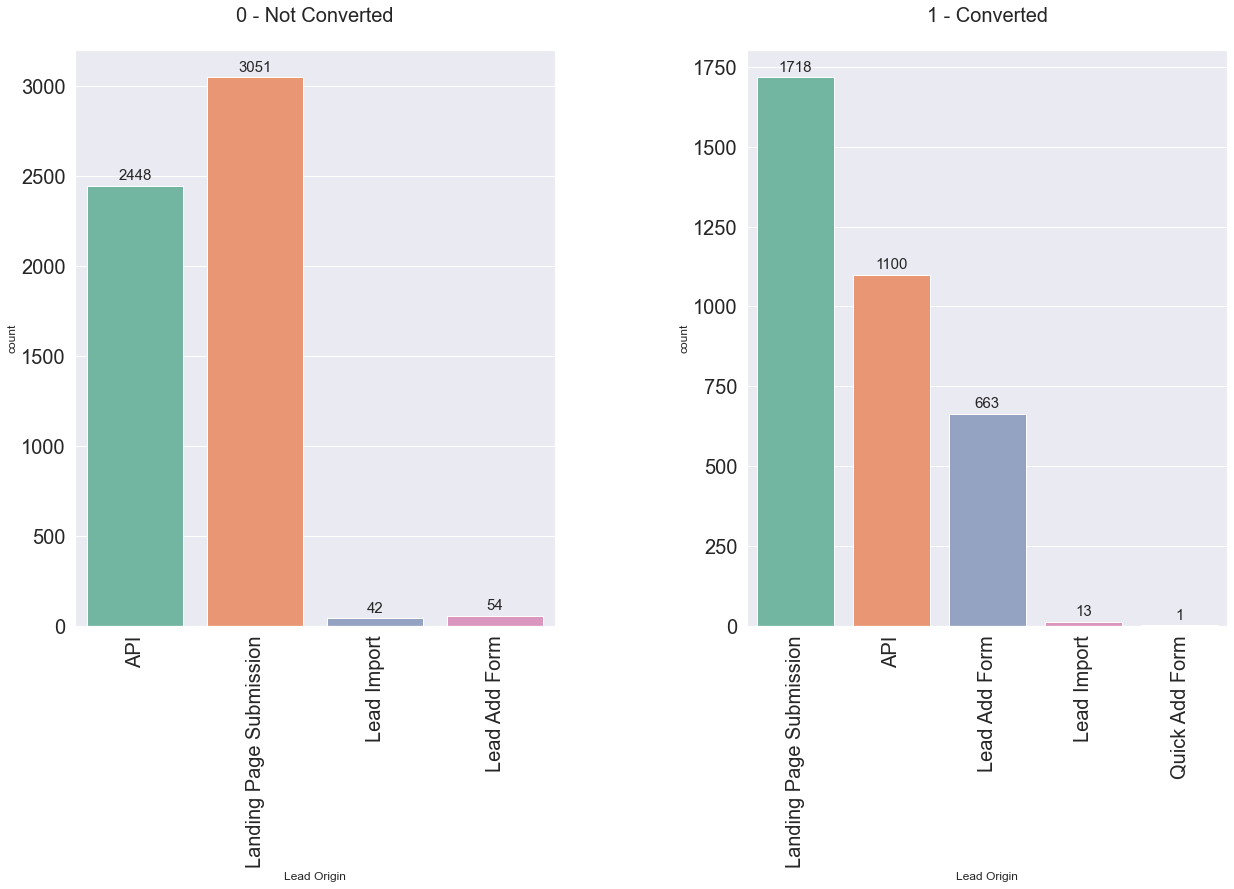

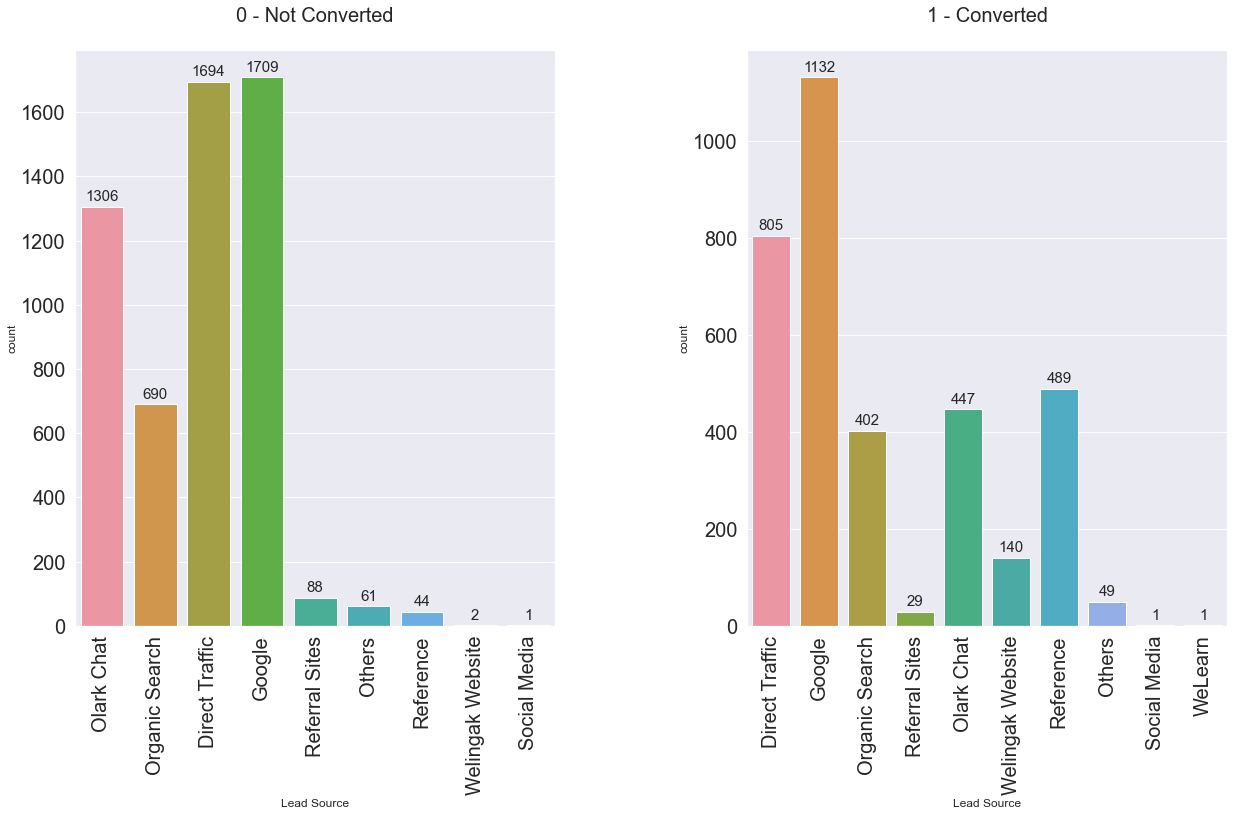

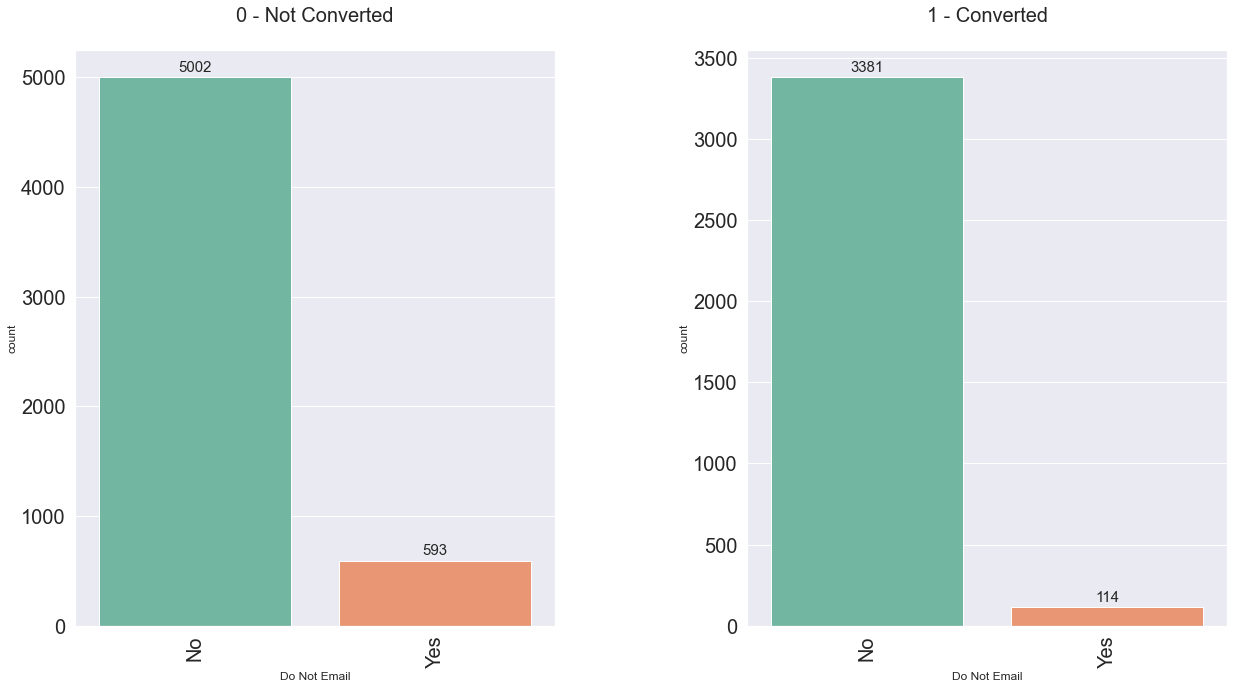

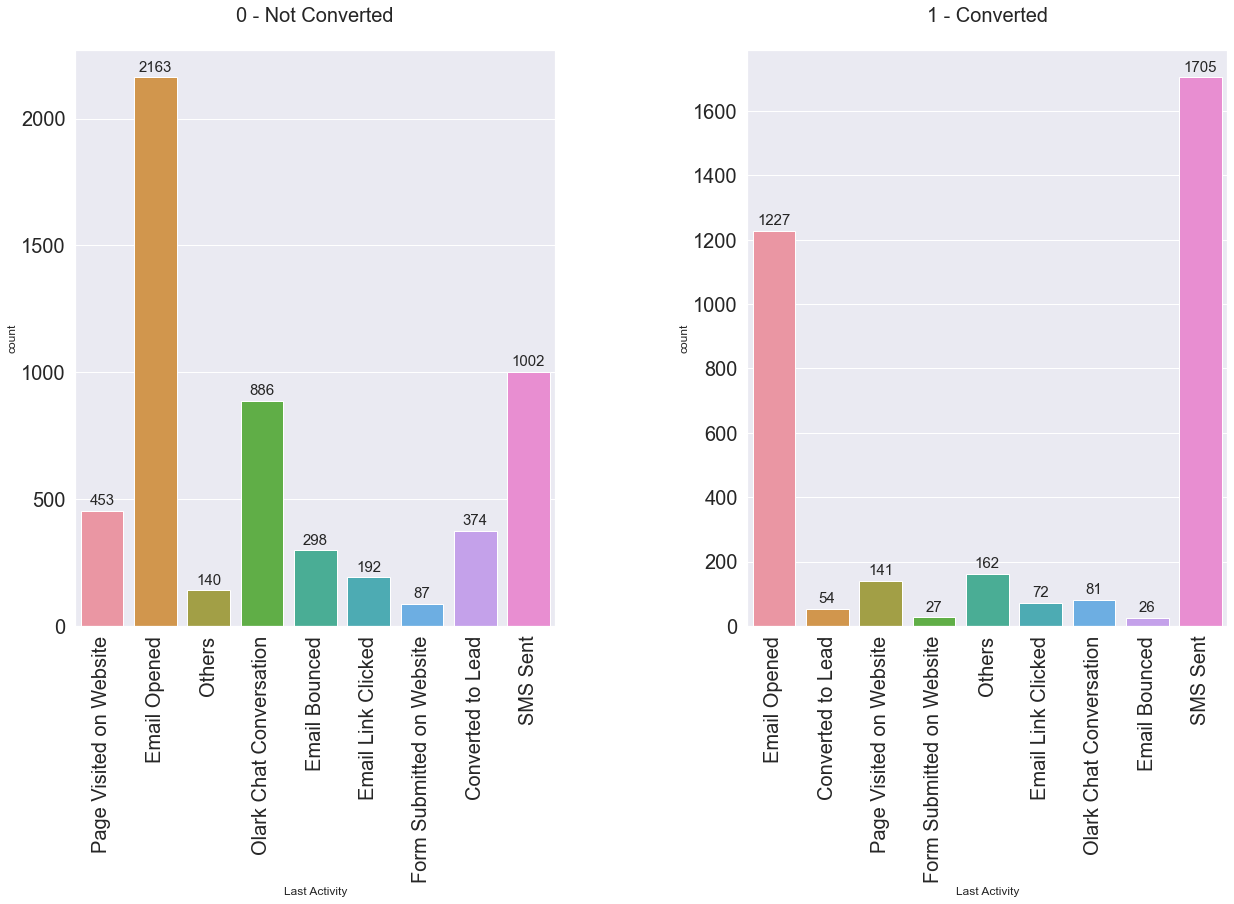

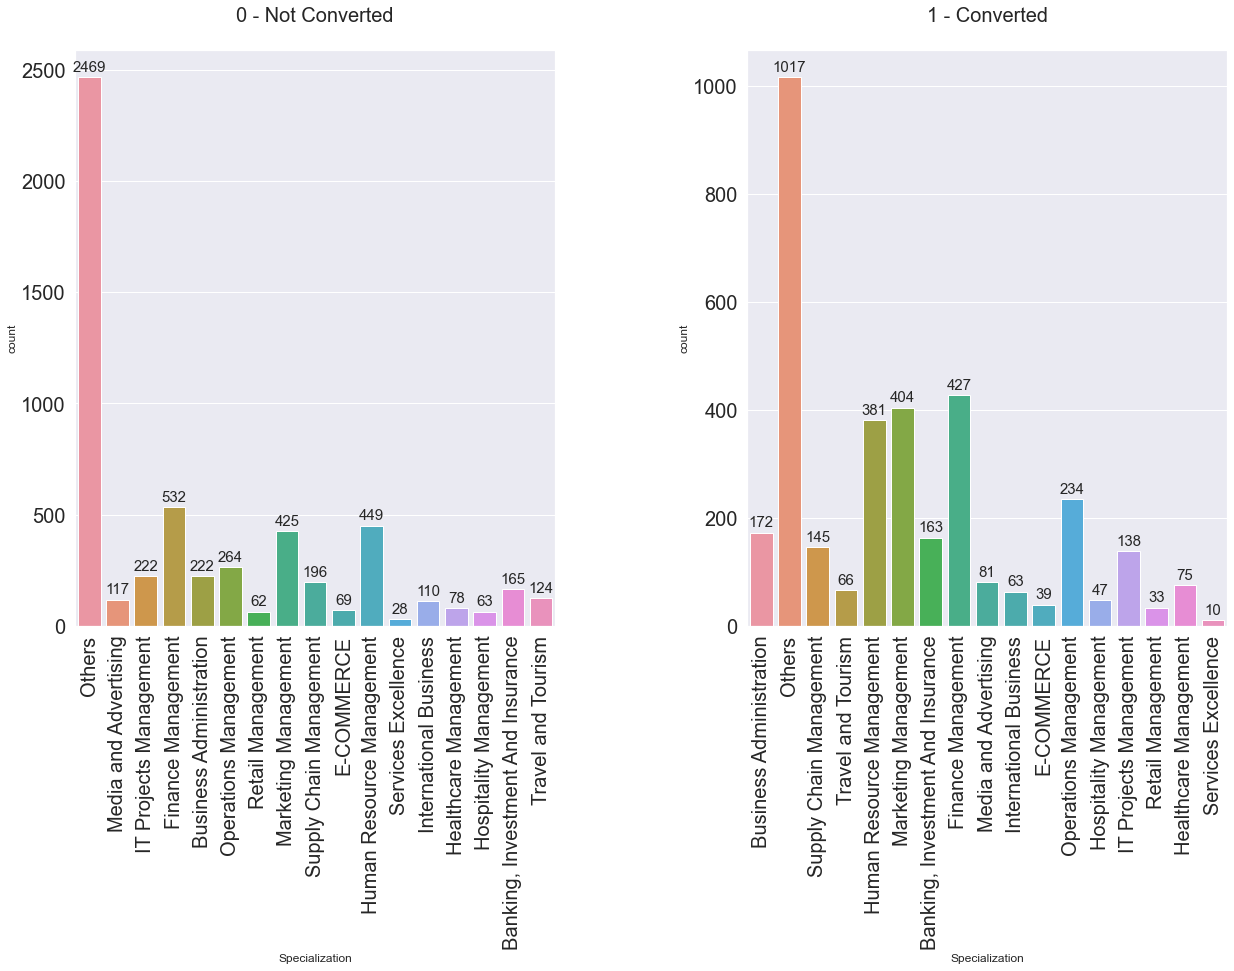

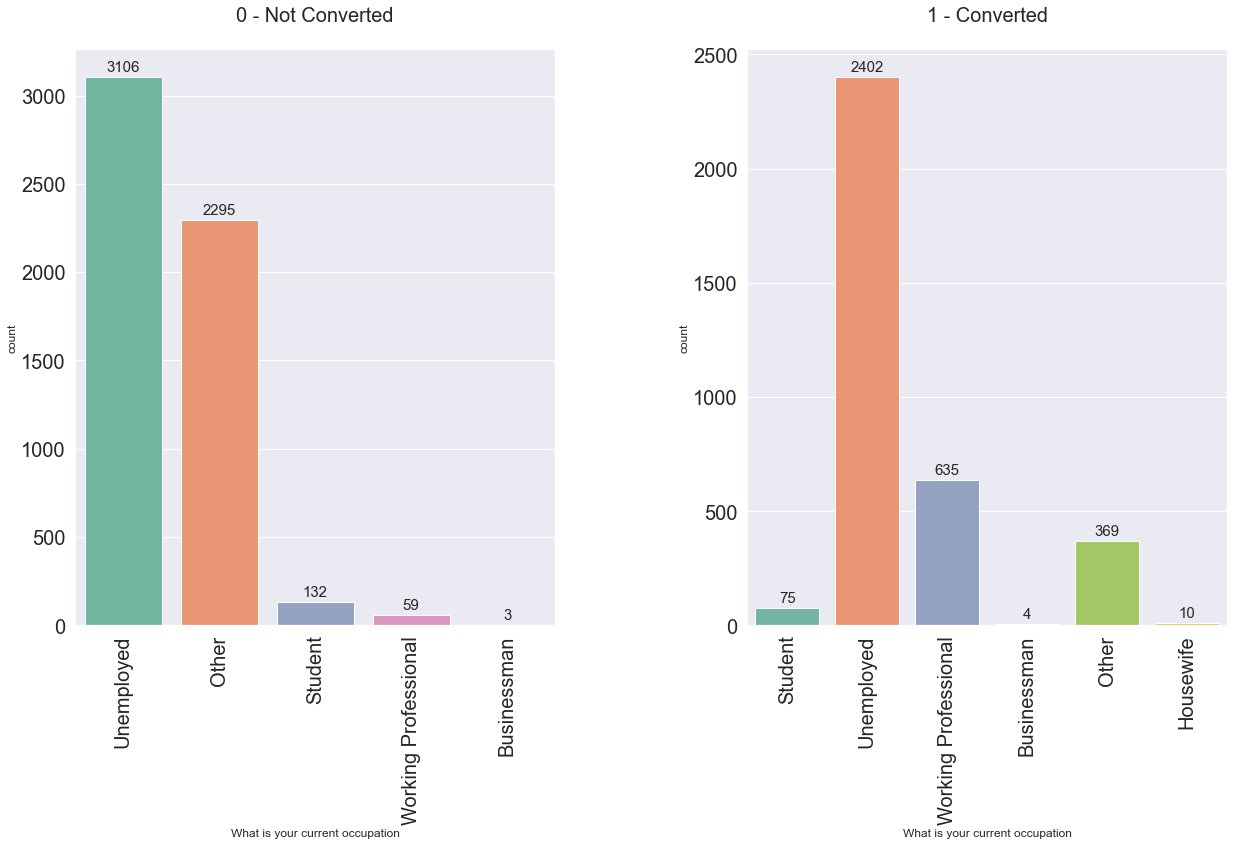

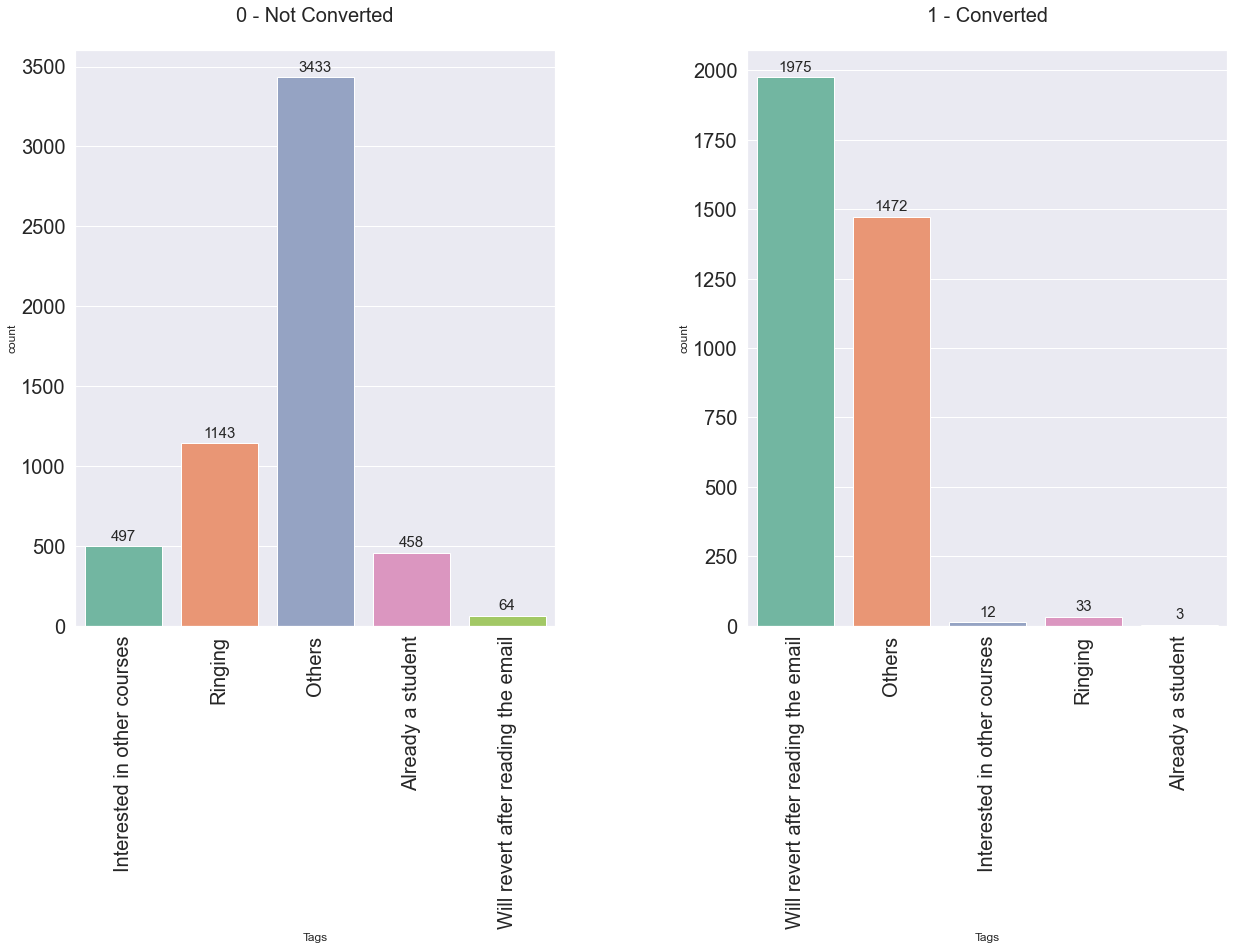

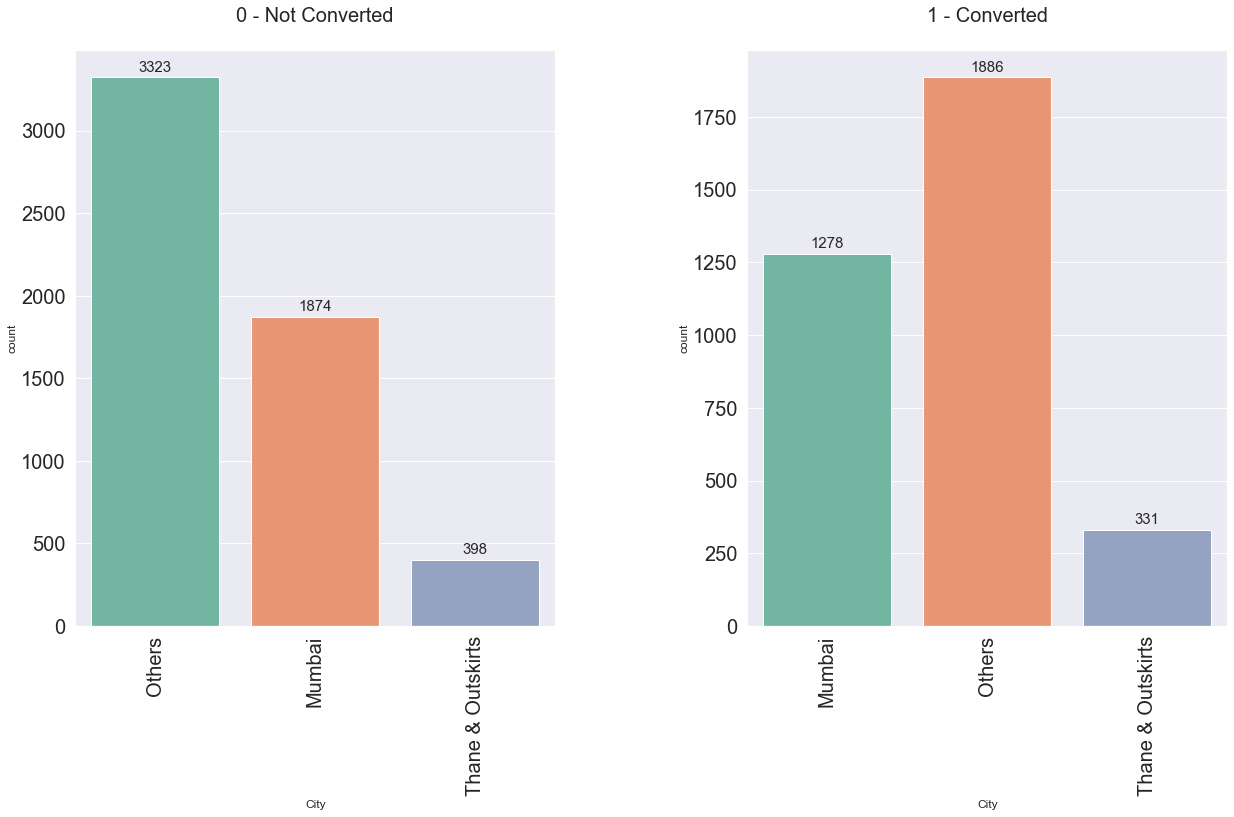

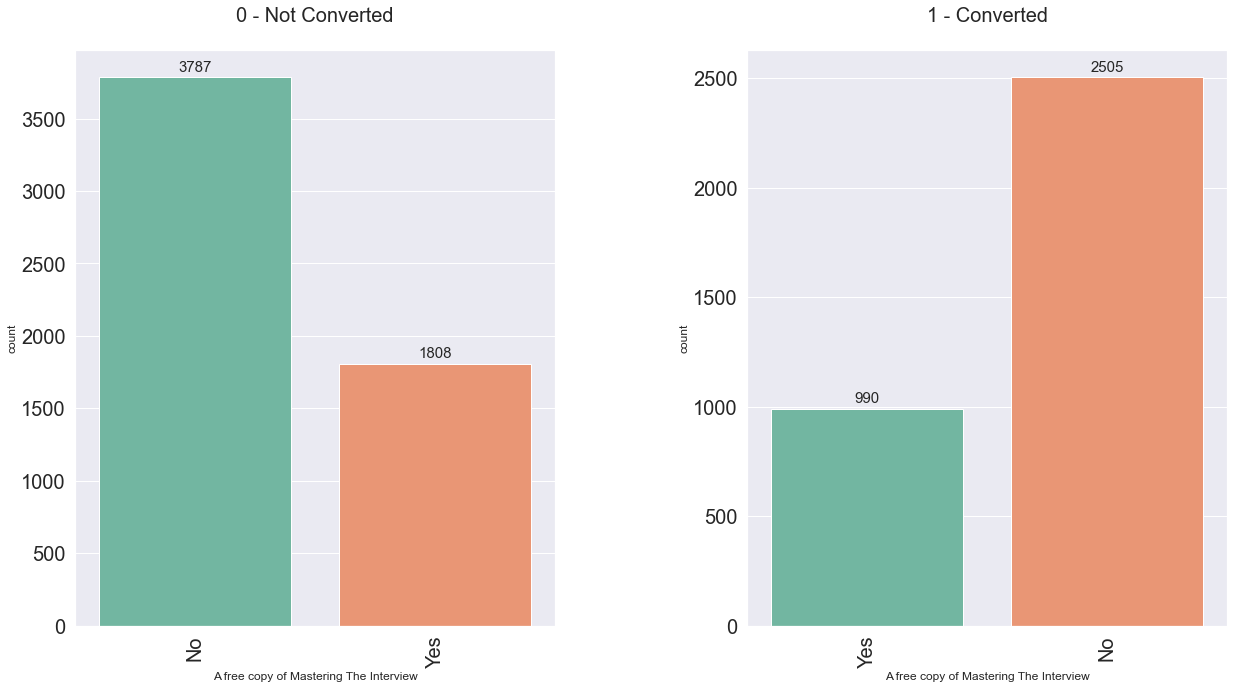

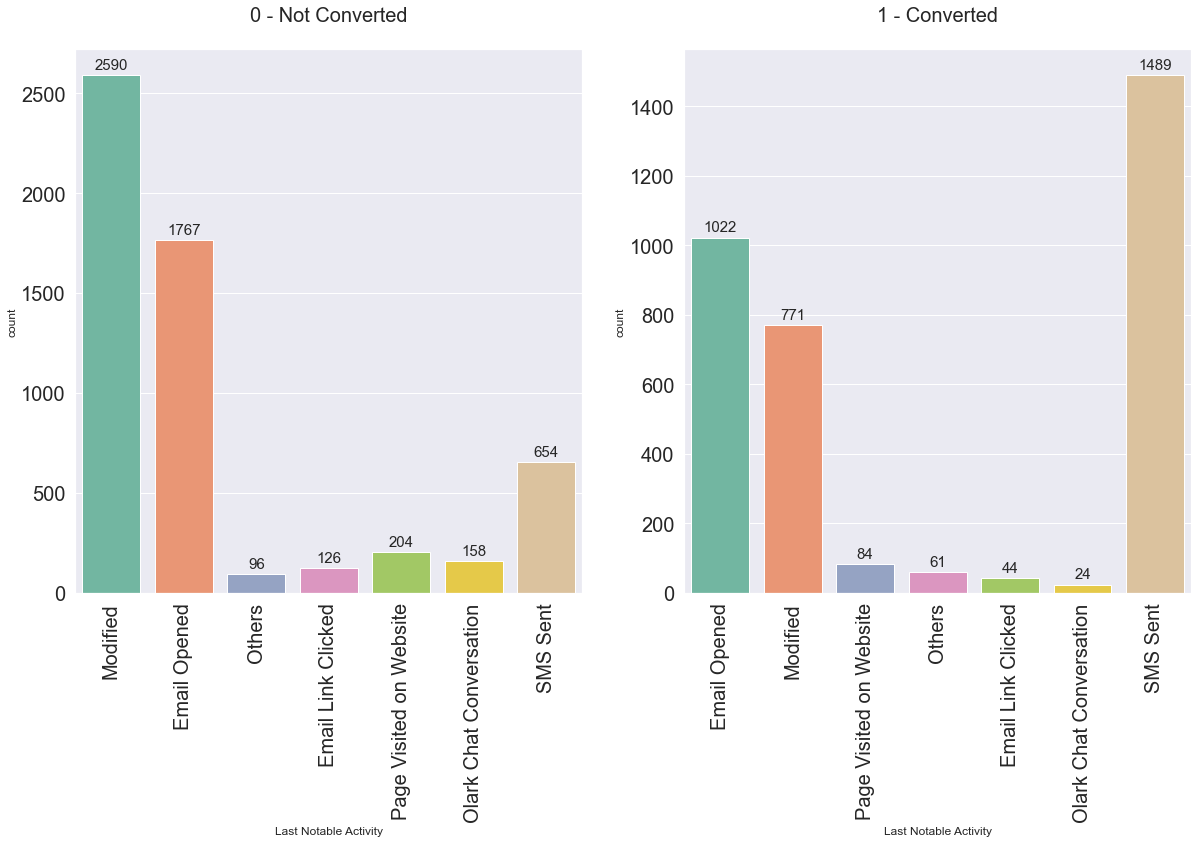

In [66]:
for x in cat_cols:
    unis(target0[x],target1[x], rotx=90)
    

_____________________________________________________________________________________________________________________


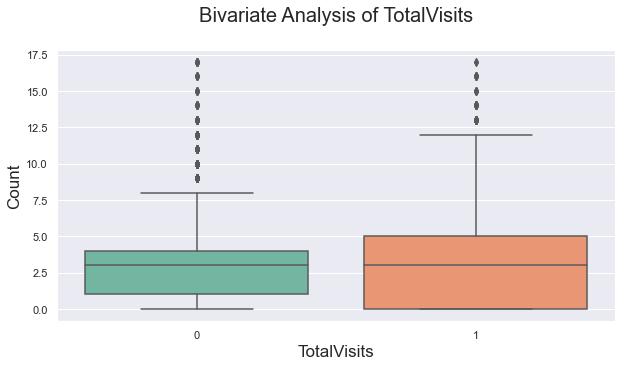

_____________________________________________________________________________________________________________________


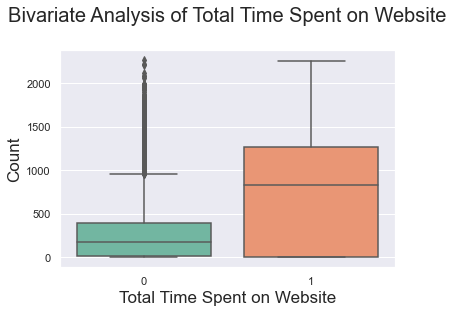

_____________________________________________________________________________________________________________________


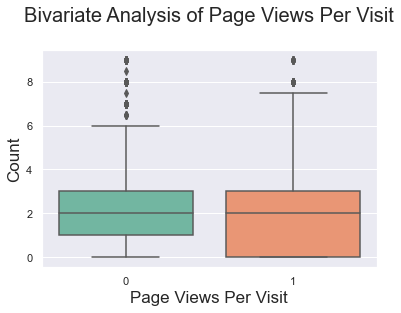

In [67]:
figure(10,5)
for i in num_cols:
    if i != 'Converted':
        
        sns.boxplot(x=xleads['Converted'],y=xleads[i])
        plt.title(f'Bivariate Analysis of {i}\n', fontdict={'size':20})
        plt.xlabel(i,size=17)
        plt.ylabel('Count',size=17)
        print('_____________________________________________________________________________________________________________________')
        plt.show()    
          
        

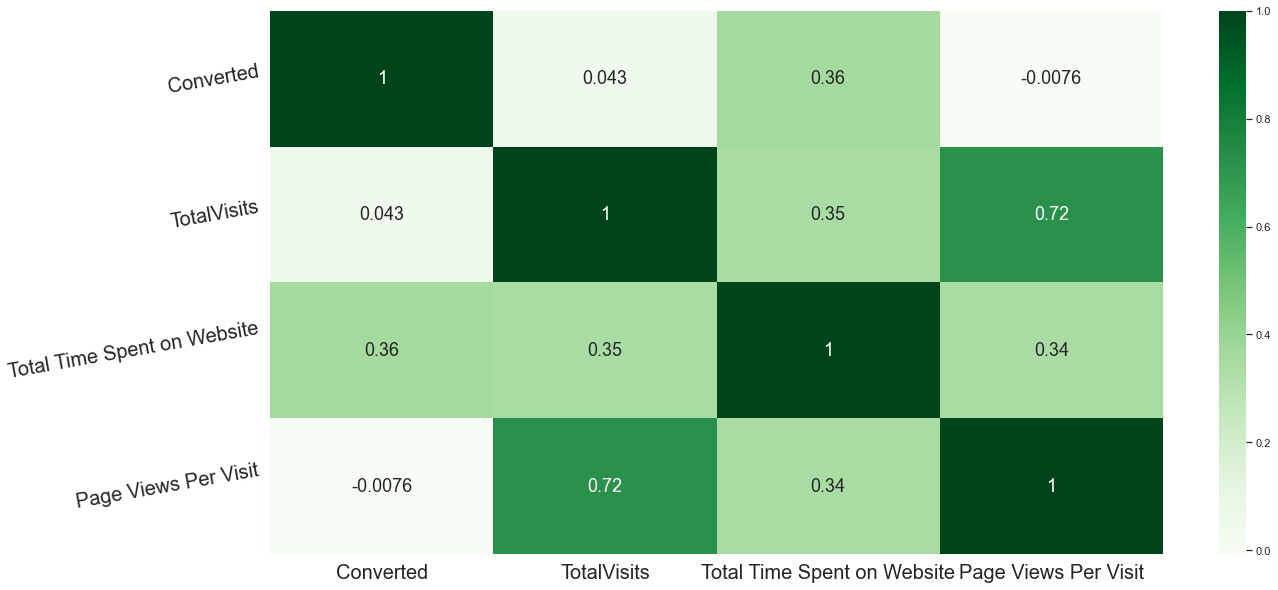

In [68]:
figure(20,10)
sns.heatmap(xleads[num_cols].corr(),cmap='Greens',annot=True,annot_kws={"size": 18})
plt.xticks(size=20)
plt.yticks(size=20, rotation=10)
plt.show()

__Insights:__

1.  "Landing Page Submission" has highest chances of getting converted compared to APIs & Lead Add Form.
2.  "Google" & "Direct Traffic" leads must be given more emphasis.
3.  Chances are that if the lead has opened the email & not responded then he/she may not be converted. But the company should focus on sending "SMS" as it has high chances of lead conversion.
4.  Leads who are from "Financial Management, HR Management & Marketing Management" specializations will be more likely to react positively towards the sale.
5.  The leads with status "Will revert after  reading the email" have more conversion rate comparatively.
6. "TotalVisits" has almost same median for both converted and non-converted leads, although leads who made more than 5 visits atleast are potential conversions.
7. It's clear that the greater the "Time spent on website" the more leads are interested and more the conversion.

## Step-4: Data Pre-Processing

In [69]:
xleads.shape

(9090, 14)

In [70]:
xleads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9090 entries, 0 to 9239
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9090 non-null   object 
 1   Lead Source                             9090 non-null   object 
 2   Do Not Email                            9090 non-null   object 
 3   Converted                               9090 non-null   int64  
 4   TotalVisits                             9090 non-null   float64
 5   Total Time Spent on Website             9090 non-null   int64  
 6   Page Views Per Visit                    9090 non-null   float64
 7   Last Activity                           9090 non-null   object 
 8   Specialization                          9090 non-null   object 
 9   What is your current occupation         9090 non-null   object 
 10  Tags                                    9090 non-null   obje

__Converting Yes/No to 1/0__

In [71]:
cat_cols

['Lead Origin',
 'Lead Source',
 'Do Not Email',
 'Last Activity',
 'Specialization',
 'What is your current occupation',
 'Tags',
 'City',
 'A free copy of Mastering The Interview',
 'Last Notable Activity']

In [72]:
yes_no_columns = ['Do Not Email','A free copy of Mastering The Interview']

xleads[yes_no_columns] = xleads[yes_no_columns].apply(lambda x: x.map({'Yes':1,'No':0}))




In [73]:
xleads.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,City,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,0,0,0.0,0,0.0,Page Visited on Website,Others,Unemployed,Interested in other courses,Others,0,Modified
1,API,Organic Search,0,0,5.0,674,2.5,Email Opened,Others,Unemployed,Ringing,Others,0,Email Opened
2,Landing Page Submission,Direct Traffic,0,1,2.0,1532,2.0,Email Opened,Business Administration,Student,Will revert after reading the email,Mumbai,1,Email Opened
3,Landing Page Submission,Direct Traffic,0,0,1.0,305,1.0,Others,Media and Advertising,Unemployed,Ringing,Mumbai,0,Modified
4,Landing Page Submission,Google,0,1,2.0,1428,1.0,Converted to Lead,Others,Unemployed,Will revert after reading the email,Mumbai,0,Modified


In [74]:
xleads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9090 entries, 0 to 9239
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9090 non-null   object 
 1   Lead Source                             9090 non-null   object 
 2   Do Not Email                            9090 non-null   int64  
 3   Converted                               9090 non-null   int64  
 4   TotalVisits                             9090 non-null   float64
 5   Total Time Spent on Website             9090 non-null   int64  
 6   Page Views Per Visit                    9090 non-null   float64
 7   Last Activity                           9090 non-null   object 
 8   Specialization                          9090 non-null   object 
 9   What is your current occupation         9090 non-null   object 
 10  Tags                                    9090 non-null   obje

In [75]:
# Sales related columns - not useful for model,has to be dropped
sales_cols = ['Last Activity','Last Notable Activity','Tags']
xleads.drop(columns=sales_cols,inplace=True)

In [76]:
xleads.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Specialization,What is your current occupation,City,A free copy of Mastering The Interview
0,API,Olark Chat,0,0,0.0,0,0.0,Others,Unemployed,Others,0
1,API,Organic Search,0,0,5.0,674,2.5,Others,Unemployed,Others,0
2,Landing Page Submission,Direct Traffic,0,1,2.0,1532,2.0,Business Administration,Student,Mumbai,1
3,Landing Page Submission,Direct Traffic,0,0,1.0,305,1.0,Media and Advertising,Unemployed,Mumbai,0
4,Landing Page Submission,Google,0,1,2.0,1428,1.0,Others,Unemployed,Mumbai,0


__Dummy Variables__

In [77]:
object_cols = xleads.select_dtypes('object').columns
object_cols

Index(['Lead Origin', 'Lead Source', 'Specialization',
       'What is your current occupation', 'City'],
      dtype='object')

In [78]:
dummy = pd.get_dummies(xleads[object_cols], drop_first=True)
xleads = pd.concat([xleads,dummy], axis=1)
xleads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9090 entries, 0 to 9239
Data columns (total 47 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Lead Origin                                           9090 non-null   object 
 1   Lead Source                                           9090 non-null   object 
 2   Do Not Email                                          9090 non-null   int64  
 3   Converted                                             9090 non-null   int64  
 4   TotalVisits                                           9090 non-null   float64
 5   Total Time Spent on Website                           9090 non-null   int64  
 6   Page Views Per Visit                                  9090 non-null   float64
 7   Specialization                                        9090 non-null   object 
 8   What is your current occupation                       9090

__There are few dummy columns with "Others" & "Not Specified" , lets drop them__

In [79]:
xleads.drop(columns=['Lead Source_Others','Specialization_Others','What is your current occupation_Other'], inplace=True)

In [80]:
xleads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9090 entries, 0 to 9239
Data columns (total 44 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Lead Origin                                           9090 non-null   object 
 1   Lead Source                                           9090 non-null   object 
 2   Do Not Email                                          9090 non-null   int64  
 3   Converted                                             9090 non-null   int64  
 4   TotalVisits                                           9090 non-null   float64
 5   Total Time Spent on Website                           9090 non-null   int64  
 6   Page Views Per Visit                                  9090 non-null   float64
 7   Specialization                                        9090 non-null   object 
 8   What is your current occupation                       9090

In [81]:
#Dropping Original Columns
orig_cols = ['Lead Origin','Do Not Email','Lead Source','Specialization','What is your current occupation','City',
             ]

xleads.drop(columns=orig_cols,inplace=True)

## Step-5: Train-Test Split & Feature Scaling

In [82]:
xleads.head()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Specialization_Business Administration,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,City_Others,City_Thane & Outskirts
0,0,0.0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,0,5.0,674,2.5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,1,2.0,1532,2.0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,1.0,305,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,1,2.0,1428,1.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [83]:
#Dividing to X & y variables
y = xleads.pop('Converted')
X = xleads

In [84]:
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.7,test_size=0.3, random_state=100)

In [85]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(6363, 37) (2727, 37) (6363,) (2727,)


__Feature Scaling__

In [86]:
scaler = StandardScaler()
cols_to_scale = ['TotalVisits','Total Time Spent on Website','Page Views Per Visit']
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_train.head(10)

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Specialization_Business Administration,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,City_Others,City_Thane & Outskirts
302,1.336782,-0.428736,0.044021,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6087,-1.094877,-0.887355,-1.206716,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1033,0.642022,-0.025151,1.477269,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
7656,0.989402,-0.241619,2.014065,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3241,0.294642,0.897591,-0.492776,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
5738,-0.400118,-0.826817,-0.133122,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
7366,-1.094877,-0.887355,-1.206716,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3680,-0.052738,-0.637866,-0.401520,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4170,0.294642,0.816874,0.940472,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
43,0.642022,-0.480101,1.477269,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Step-6: Model Building

__Feature Selection Using RFE__

In [87]:
logreg = LogisticRegression()

In [88]:
rfe = RFE(estimator=logreg,n_features_to_select=15)
rfe = rfe.fit(X_train,y_train)

In [89]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('TotalVisits', False, 13),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 19),
 ('A free copy of Mastering The Interview', False, 14),
 ('Lead Origin_Landing Page Submission', False, 9),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 6),
 ('Lead Origin_Quick Add Form', False, 21),
 ('Lead Source_Google', True, 1),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', False, 16),
 ('Lead Source_Reference', False, 15),
 ('Lead Source_Referral Sites', False, 22),
 ('Lead Source_Social Media', False, 10),
 ('Lead Source_WeLearn', True, 1),
 ('Lead Source_Welingak Website', True, 1),
 ('Specialization_Business Administration', False, 12),
 ('Specialization_E-COMMERCE', True, 1),
 ('Specialization_Finance Management', False, 3),
 ('Specialization_Healthcare Management', False, 8),
 ('Specialization_Hospitality Management', True, 1),
 ('Specialization_Human Resource Management', False, 4),
 ('Specialization_IT Projec

In [90]:
rfe_cols = X_train.columns[rfe.support_]
rfe_cols

Index(['Total Time Spent on Website', 'Lead Origin_Lead Add Form',
       'Lead Source_Google', 'Lead Source_Olark Chat', 'Lead Source_WeLearn',
       'Lead Source_Welingak Website', 'Specialization_E-COMMERCE',
       'Specialization_Hospitality Management',
       'Specialization_Marketing Management',
       'Specialization_Media and Advertising',
       'Specialization_Operations Management',
       'What is your current occupation_Housewife',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional'],
      dtype='object')

__Model Building__

In [91]:
# Model - 1
X_train_sm = sm.add_constant(X_train[rfe_cols])
logm1 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
model1 = logm1.fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6363
Model:                            GLM   Df Residuals:                     6347
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2866.5
Date:                Sun, 13 Mar 2022   Deviance:                       5732.9
Time:                        18:33:54   Pearson chi2:                 6.92e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3486
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.3843      0.090    -26.566      0.000      -2.560      -2.208
Total Time Spent on Website                              1.0948      0.038     28.461      0.000       1.019       1.170
Lead Origin_Lead Add Form                                3.6422      0.195     18.674      0.000       3.260       4.025
Lead Source_Google                                       0.3729      0.076      4.926      0.000       0.225       0.521
Lead Source_Olark Chat                                   1.2033      0.104     11.623      0.000       1.000       1.406
Lead Source_WeLearn                                     21.9115   4.82e+04      0.000      1.000   -9.44e+04    9.45e+04
Lead Source_Welingak Website                             2.8472      1.022      2.786      0.005       0.844       4.850
Specialization_E-COMMERCE                                0.4947      0.294      1.681      0.093      -0.082       1.072
Specialization_Hospitality Management                   -0.7608      0.322     -2.361      0.018      -1.393      -0.129
Specialization_Marketing Management                      0.2822      0.114      2.478      0.013       0.059       0.505
Specialization_Media and Advertising                     0.2042      0.222      0.922      0.357      -0.230       0.638
Specialization_Operations Management                     0.2461      0.146      1.690      0.091      -0.039       0.532
What is your current occupation_Housewife               23.9196   1.41e+04      0.002      0.999   -2.76e+04    2.77e+04
What is your current occupation_Student                  1.0596      0.216      4.907      0.000       0.636       1.483
What is your current occupation_Unemployed               1.3502      0.083     16.258      0.000       1.187       1.513
What is your current occupation_Working Professional     3.8351      0.190     20.215      0.000       3.463       4.207
========================================================================================================================
"""

In [92]:
#Checking VIF

vif = pd.DataFrame()
vif['Features'] = X_train[rfe_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_cols].values,i) for i in range(X_train[rfe_cols].shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
13,What is your current occupation_Unemployed,1.72
1,Lead Origin_Lead Add Form,1.59
2,Lead Source_Google,1.39
3,Lead Source_Olark Chat,1.32
5,Lead Source_Welingak Website,1.30
0,Total Time Spent on Website,1.25
14,What is your current occupation_Working Profes...,1.25
8,Specialization_Marketing Management,1.12
10,Specialization_Operations Management,1.07
9,Specialization_Media and Advertising,1.03


__Lead Source_WeLearn Has very high P-value, let's drop it__

In [93]:
rfe_cols = rfe_cols.drop('Lead Source_WeLearn')
rfe_cols

Index(['Total Time Spent on Website', 'Lead Origin_Lead Add Form',
       'Lead Source_Google', 'Lead Source_Olark Chat',
       'Lead Source_Welingak Website', 'Specialization_E-COMMERCE',
       'Specialization_Hospitality Management',
       'Specialization_Marketing Management',
       'Specialization_Media and Advertising',
       'Specialization_Operations Management',
       'What is your current occupation_Housewife',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional'],
      dtype='object')

In [94]:
# Model -2
X_train_sm1 = sm.add_constant(X_train[rfe_cols])
logm2 = sm.GLM(y_train,X_train_sm1, family = sm.families.Binomial())
model2 = logm2.fit()
model2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6363
Model:                            GLM   Df Residuals:                     6348
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2866.9
Date:                Sun, 13 Mar 2022   Deviance:                       5733.8
Time:                        18:33:55   Pearson chi2:                 6.92e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3485
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.3844      0.090    -26.566      0.000      -2.560      -2.209
Total Time Spent on Website                              1.0953      0.038     28.472      0.000       1.020       1.171
Lead Origin_Lead Add Form                                3.6418      0.195     18.672      0.000       3.260       4.024
Lead Source_Google                                       0.3720      0.076      4.914      0.000       0.224       0.520
Lead Source_Olark Chat                                   1.2033      0.104     11.623      0.000       1.000       1.406
Lead Source_Welingak Website                             2.8476      1.022      2.787      0.005       0.845       4.851
Specialization_E-COMMERCE                                0.4946      0.294      1.681      0.093      -0.082       1.072
Specialization_Hospitality Management                   -0.7610      0.322     -2.361      0.018      -1.393      -0.129
Specialization_Marketing Management                      0.2861      0.114      2.516      0.012       0.063       0.509
Specialization_Media and Advertising                     0.2042      0.222      0.922      0.357      -0.230       0.638
Specialization_Operations Management                     0.2460      0.146      1.689      0.091      -0.039       0.532
What is your current occupation_Housewife               23.9201   1.41e+04      0.002      0.999   -2.76e+04    2.77e+04
What is your current occupation_Student                  1.0597      0.216      4.908      0.000       0.636       1.483
What is your current occupation_Unemployed               1.3507      0.083     16.263      0.000       1.188       1.513
What is your current occupation_Working Professional     3.8351      0.190     20.214      0.000       3.463       4.207
========================================================================================================================
"""

In [95]:
#Checking VIF

vif = pd.DataFrame()
vif['Features'] = X_train[rfe_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_cols].values,i) for i in range(X_train[rfe_cols].shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
12,What is your current occupation_Unemployed,1.72
1,Lead Origin_Lead Add Form,1.59
2,Lead Source_Google,1.39
3,Lead Source_Olark Chat,1.32
4,Lead Source_Welingak Website,1.30
0,Total Time Spent on Website,1.25
13,What is your current occupation_Working Profes...,1.25
7,Specialization_Marketing Management,1.11
9,Specialization_Operations Management,1.07
8,Specialization_Media and Advertising,1.03


__What is your current occupation_Housewife Has very high P-value, let's drop it__

In [96]:
rfe_cols = rfe_cols.drop('What is your current occupation_Housewife')
rfe_cols

Index(['Total Time Spent on Website', 'Lead Origin_Lead Add Form',
       'Lead Source_Google', 'Lead Source_Olark Chat',
       'Lead Source_Welingak Website', 'Specialization_E-COMMERCE',
       'Specialization_Hospitality Management',
       'Specialization_Marketing Management',
       'Specialization_Media and Advertising',
       'Specialization_Operations Management',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional'],
      dtype='object')

In [97]:
# Model -3
X_train_sm2 = sm.add_constant(X_train[rfe_cols])
logm3 = sm.GLM(y_train,X_train_sm2, family = sm.families.Binomial())
model3 = logm3.fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6363
Model:                            GLM   Df Residuals:                     6349
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2878.2
Date:                Sun, 13 Mar 2022   Deviance:                       5756.4
Time:                        18:33:55   Pearson chi2:                 6.97e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3462
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.3519      0.089    -26.467      0.000      -2.526      -2.178
Total Time Spent on Website                              1.0947      0.038     28.517      0.000       1.019       1.170
Lead Origin_Lead Add Form                                3.6810      0.195     18.853      0.000       3.298       4.064
Lead Source_Google                                       0.3708      0.076      4.911      0.000       0.223       0.519
Lead Source_Olark Chat                                   1.1921      0.103     11.539      0.000       0.990       1.395
Lead Source_Welingak Website                             2.8076      1.022      2.747      0.006       0.805       4.811
Specialization_E-COMMERCE                                0.4893      0.294      1.665      0.096      -0.087       1.065
Specialization_Hospitality Management                   -0.7655      0.322     -2.375      0.018      -1.397      -0.134
Specialization_Marketing Management                      0.2800      0.114      2.463      0.014       0.057       0.503
Specialization_Media and Advertising                     0.2633      0.218      1.206      0.228      -0.165       0.691
Specialization_Operations Management                     0.2406      0.146      1.654      0.098      -0.045       0.526
What is your current occupation_Student                  1.0286      0.216      4.767      0.000       0.606       1.452
What is your current occupation_Unemployed               1.3186      0.082     16.048      0.000       1.158       1.480
What is your current occupation_Working Professional     3.8020      0.189     20.081      0.000       3.431       4.173
========================================================================================================================
"""

In [98]:
#Checking VIF

vif = pd.DataFrame()
vif['Features'] = X_train[rfe_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_cols].values,i) for i in range(X_train[rfe_cols].shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
11,What is your current occupation_Unemployed,1.72
1,Lead Origin_Lead Add Form,1.58
2,Lead Source_Google,1.39
3,Lead Source_Olark Chat,1.32
4,Lead Source_Welingak Website,1.29
0,Total Time Spent on Website,1.25
12,What is your current occupation_Working Profes...,1.25
7,Specialization_Marketing Management,1.11
9,Specialization_Operations Management,1.07
8,Specialization_Media and Advertising,1.03


__Specialization_Media and Advertising Has very high P-value, let's drop it__

In [99]:
rfe_cols = rfe_cols.drop('Specialization_Media and Advertising')
rfe_cols

Index(['Total Time Spent on Website', 'Lead Origin_Lead Add Form',
       'Lead Source_Google', 'Lead Source_Olark Chat',
       'Lead Source_Welingak Website', 'Specialization_E-COMMERCE',
       'Specialization_Hospitality Management',
       'Specialization_Marketing Management',
       'Specialization_Operations Management',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional'],
      dtype='object')

In [100]:
# Model -4
X_train_sm3 = sm.add_constant(X_train[rfe_cols])
logm4 = sm.GLM(y_train,X_train_sm3, family = sm.families.Binomial())
model4 = logm4.fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6363
Model:                            GLM   Df Residuals:                     6350
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2878.9
Date:                Sun, 13 Mar 2022   Deviance:                       5757.9
Time:                        18:33:55   Pearson chi2:                 6.98e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3461
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.3450      0.089    -26.452      0.000      -2.519      -2.171
Total Time Spent on Website                              1.0946      0.038     28.520      0.000       1.019       1.170
Lead Origin_Lead Add Form                                3.6751      0.195     18.829      0.000       3.293       4.058
Lead Source_Google                                       0.3709      0.076      4.912      0.000       0.223       0.519
Lead Source_Olark Chat                                   1.1859      0.103     11.498      0.000       0.984       1.388
Lead Source_Welingak Website                             2.8042      1.022      2.744      0.006       0.801       4.807
Specialization_E-COMMERCE                                0.4802      0.294      1.634      0.102      -0.096       1.056
Specialization_Hospitality Management                   -0.7744      0.322     -2.403      0.016      -1.406      -0.143
Specialization_Marketing Management                      0.2716      0.113      2.394      0.017       0.049       0.494
Specialization_Operations Management                     0.2319      0.145      1.595      0.111      -0.053       0.517
What is your current occupation_Student                  1.0267      0.216      4.757      0.000       0.604       1.450
What is your current occupation_Unemployed               1.3212      0.082     16.085      0.000       1.160       1.482
What is your current occupation_Working Professional     3.8086      0.189     20.125      0.000       3.438       4.180
========================================================================================================================
"""

In [101]:
#Checking VIF

vif = pd.DataFrame()
vif['Features'] = X_train[rfe_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_cols].values,i) for i in range(X_train[rfe_cols].shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
10,What is your current occupation_Unemployed,1.69
1,Lead Origin_Lead Add Form,1.58
2,Lead Source_Google,1.39
3,Lead Source_Olark Chat,1.32
4,Lead Source_Welingak Website,1.29
0,Total Time Spent on Website,1.25
11,What is your current occupation_Working Profes...,1.24
7,Specialization_Marketing Management,1.11
8,Specialization_Operations Management,1.07
9,What is your current occupation_Student,1.03


__Specialization_Operations Management Has very high P-Value, let's drop it__

In [102]:
rfe_cols = rfe_cols.drop('Specialization_Operations Management')
rfe_cols

Index(['Total Time Spent on Website', 'Lead Origin_Lead Add Form',
       'Lead Source_Google', 'Lead Source_Olark Chat',
       'Lead Source_Welingak Website', 'Specialization_E-COMMERCE',
       'Specialization_Hospitality Management',
       'Specialization_Marketing Management',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional'],
      dtype='object')

In [103]:
# Model -5
X_train_sm4 = sm.add_constant(X_train[rfe_cols])
logm5 = sm.GLM(y_train,X_train_sm4, family = sm.families.Binomial())
model5 = logm5.fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6363
Model:                            GLM   Df Residuals:                     6351
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2880.2
Date:                Sun, 13 Mar 2022   Deviance:                       5760.4
Time:                        18:33:56   Pearson chi2:                 7.00e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3458
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.3279      0.088    -26.484      0.000      -2.500      -2.156
Total Time Spent on Website                              1.0952      0.038     28.545      0.000       1.020       1.170
Lead Origin_Lead Add Form                                3.6646      0.195     18.790      0.000       3.282       4.047
Lead Source_Google                                       0.3670      0.075      4.864      0.000       0.219       0.515
Lead Source_Olark Chat                                   1.1731      0.103     11.428      0.000       0.972       1.374
Lead Source_Welingak Website                             2.7992      1.022      2.739      0.006       0.796       4.802
Specialization_E-COMMERCE                                0.4624      0.294      1.574      0.115      -0.113       1.038
Specialization_Hospitality Management                   -0.7926      0.322     -2.459      0.014      -1.424      -0.161
Specialization_Marketing Management                      0.2556      0.113      2.262      0.024       0.034       0.477
What is your current occupation_Student                  1.0236      0.216      4.747      0.000       0.601       1.446
What is your current occupation_Unemployed               1.3226      0.082     16.105      0.000       1.162       1.484
What is your current occupation_Working Professional     3.8258      0.189     20.253      0.000       3.456       4.196
========================================================================================================================
"""

In [104]:
#Checking VIF

vif = pd.DataFrame()
vif['Features'] = X_train[rfe_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_cols].values,i) for i in range(X_train[rfe_cols].shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
9,What is your current occupation_Unemployed,1.66
1,Lead Origin_Lead Add Form,1.58
2,Lead Source_Google,1.39
3,Lead Source_Olark Chat,1.32
4,Lead Source_Welingak Website,1.29
0,Total Time Spent on Website,1.25
10,What is your current occupation_Working Profes...,1.22
7,Specialization_Marketing Management,1.11
8,What is your current occupation_Student,1.03
6,Specialization_Hospitality Management,1.02


__Specialization_E-COMMERCE and Advertising Has very high P-Value, let's drop it__

In [105]:
rfe_cols = rfe_cols.drop('Specialization_E-COMMERCE')
rfe_cols

Index(['Total Time Spent on Website', 'Lead Origin_Lead Add Form',
       'Lead Source_Google', 'Lead Source_Olark Chat',
       'Lead Source_Welingak Website', 'Specialization_Hospitality Management',
       'Specialization_Marketing Management',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional'],
      dtype='object')

In [106]:
# Model - 6
X_train_sm5 = sm.add_constant(X_train[rfe_cols])
logm6 = sm.GLM(y_train,X_train_sm5, family = sm.families.Binomial())
model6 = logm6.fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6363
Model:                            GLM   Df Residuals:                     6352
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2881.4
Date:                Sun, 13 Mar 2022   Deviance:                       5762.8
Time:                        18:33:56   Pearson chi2:                 7.00e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3456
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.3170      0.088    -26.463      0.000      -2.489      -2.145
Total Time Spent on Website                              1.0929      0.038     28.539      0.000       1.018       1.168
Lead Origin_Lead Add Form                                3.6525      0.195     18.748      0.000       3.271       4.034
Lead Source_Google                                       0.3614      0.075      4.797      0.000       0.214       0.509
Lead Source_Olark Chat                                   1.1610      0.102     11.354      0.000       0.961       1.361
Lead Source_Welingak Website                             2.7978      1.022      2.738      0.006       0.795       4.801
Specialization_Hospitality Management                   -0.7990      0.322     -2.480      0.013      -1.430      -0.168
Specialization_Marketing Management                      0.2484      0.113      2.201      0.028       0.027       0.470
What is your current occupation_Student                  1.0190      0.216      4.727      0.000       0.596       1.441
What is your current occupation_Unemployed               1.3234      0.082     16.116      0.000       1.162       1.484
What is your current occupation_Working Professional     3.8276      0.189     20.261      0.000       3.457       4.198
========================================================================================================================
"""

In [107]:
#Checking VIF

vif = pd.DataFrame()
vif['Features'] = X_train[rfe_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_cols].values,i) for i in range(X_train[rfe_cols].shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
8,What is your current occupation_Unemployed,1.64
1,Lead Origin_Lead Add Form,1.58
2,Lead Source_Google,1.39
3,Lead Source_Olark Chat,1.31
4,Lead Source_Welingak Website,1.29
0,Total Time Spent on Website,1.25
9,What is your current occupation_Working Profes...,1.21
6,Specialization_Marketing Management,1.10
7,What is your current occupation_Student,1.03
5,Specialization_Hospitality Management,1.02


### Model-6 looks very good with as all P-values < 0.05 & VIF Scores <5

In [108]:
# Predicting

y_train_pred = model6.predict(X_train_sm5)
y_train_pred

302     0.058108
6087    0.106612
1033    0.340805
7656    0.221373
3241    0.496853
          ...   
360     0.309504
81      0.994407
8171    0.560217
7048    0.624503
5730    0.129737
Length: 6363, dtype: float64

### Creating DataFrame for further evaluations

In [109]:
resultdf = pd.DataFrame({'Prospect ID': y_train.index,'Converted': y_train.values,'Converted_prob':y_train_pred})

In [110]:
resultdf.reset_index(drop=True,inplace=True)

In [111]:
resultdf.head()

,Prospect ID,Converted,Converted_prob
0,302,0,0.058108
1,6087,0,0.106612
2,1033,0,0.340805
3,7656,0,0.221373
4,3241,1,0.496853


## Step-7: ROC Curve & Optimal Cutoff

__Plotting ROC Curve__

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [112]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate/Specificity]')
    plt.ylabel('True Positive Rate/Sensitivity')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

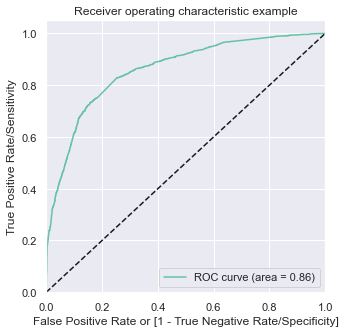

In [113]:
draw_roc(resultdf.Converted,resultdf.Converted_prob)

__The ROC Curve looks good as area under the curve is 0.86__

__Finding Optimal Cutoff__

To determine the optimal cutoff we would use Precision-Recall Trade-off

In [114]:
precision,recall,threshold = precision_recall_curve(resultdf.Converted,resultdf.Converted_prob)

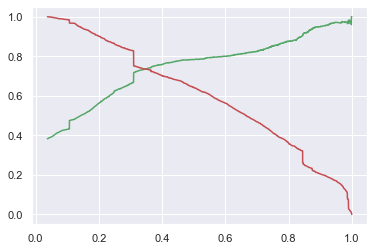

In [115]:
plt.plot(threshold,precision[:-1],"g-")
plt.plot(threshold,recall[:-1],"r-")
plt.show()

__From the above we can see 0.38 looks as optimal cutoff__

In [116]:
resultdf['Converted_Predicted'] = resultdf.Converted_prob.apply(lambda x : 1 if x>0.38 else 0)
resultdf.head()

,Prospect ID,Converted,Converted_prob,Converted_Predicted
0,302,0,0.058108,0
1,6087,0,0.106612,0
2,1033,0,0.340805,0
3,7656,0,0.221373,0
4,3241,1,0.496853,1


In [117]:
print(classification_report(resultdf.Converted,resultdf.Converted_Predicted))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      3935
           1       0.75      0.72      0.73      2428

    accuracy                           0.80      6363
   macro avg       0.79      0.79      0.79      6363
weighted avg       0.80      0.80      0.80      6363



__Finding Optimal Cutoff using Sensitivity/Specificty/Accuracy__

In [118]:
nums = [i/10 for i in range(0,11)]
nums

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [119]:
resultdf1= pd.DataFrame({'Prospect ID': y_train.index,'Converted': y_train.values,'Converted_prob':y_train_pred})
resultdf1.reset_index(drop=True, inplace=True)
resultdf1

,Prospect ID,Converted,Converted_prob
0,302,0,0.058108
1,6087,0,0.106612
2,1033,0,0.340805
3,7656,0,0.221373
4,3241,1,0.496853
...,...,...,...
6358,360,0,0.309504
6359,81,1,0.994407
6360,8171,1,0.560217
6361,7048,1,0.624503


In [120]:
# calculating predicted values for all cutoffs
for i in nums:
    resultdf1[i] = resultdf1.Converted_prob.apply(lambda x: 1 if x > i else 0)

In [121]:
resultdf1.head()

,Prospect ID,Converted,Converted_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,302,0,0.058108,1,0,0,0,0,0,0,0,0,0,0
1,6087,0,0.106612,1,1,0,0,0,0,0,0,0,0,0
2,1033,0,0.340805,1,1,1,1,0,0,0,0,0,0,0
3,7656,0,0.221373,1,1,1,0,0,0,0,0,0,0,0
4,3241,1,0.496853,1,1,1,1,1,0,0,0,0,0,0


In [122]:
#Now let's calculate sensitivity/Specificity/accuracy
cutoff_df = pd.DataFrame( columns = ['cutoff','accuracy','sensitivity','specificity'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(resultdf1.Converted, resultdf1[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    
    
print(cutoff_df)

     cutoff  accuracy  sensitivity  specificity
0.0     0.0  0.381581     1.000000     0.000000
0.1     0.1  0.497250     0.985173     0.196188
0.2     0.2  0.694641     0.901153     0.567217
0.3     0.3  0.772434     0.830725     0.736468
0.4     0.4  0.800251     0.700988     0.861499
0.5     0.5  0.795537     0.641680     0.890470
0.6     0.6  0.779507     0.563015     0.913088
0.7     0.7  0.759076     0.468287     0.938501
0.8     0.8  0.735974     0.359143     0.968488
0.9     0.9  0.692441     0.204695     0.993393


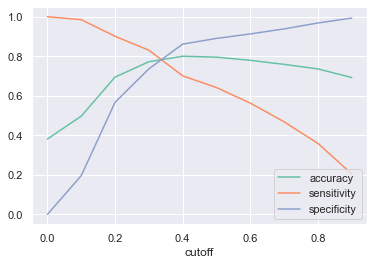

In [123]:
# Let's plot accuracy sensitivity and specificity for various cutoff probabailities.
cutoff_df.plot(x='cutoff',y=['accuracy','sensitivity','specificity'])
plt.legend(loc='lower right')
plt.show()

__From the above we can see 0.38 is the optimal cutoff as per sesitivity/secificity/accuracy trade-off__

In [124]:
resultdf1['Converted_Predicted'] = resultdf1.Converted_prob.map(lambda x: 1 if x>0.38 else 0)
resultdf1.head()

,Prospect ID,Converted,Converted_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,Converted_Predicted
0,302,0,0.058108,1,0,0,0,0,0,0,0,0,0,0,0
1,6087,0,0.106612,1,1,0,0,0,0,0,0,0,0,0,0
2,1033,0,0.340805,1,1,1,1,0,0,0,0,0,0,0,0
3,7656,0,0.221373,1,1,1,0,0,0,0,0,0,0,0,0
4,3241,1,0.496853,1,1,1,1,1,0,0,0,0,0,0,1


In [125]:
confusion2 = confusion_matrix(resultdf1.Converted,resultdf1.Converted_Predicted)
confusion2

array([[3363,  572],
       [ 690, 1738]], dtype=int64)

In [126]:
metrics.accuracy_score(resultdf1.Converted,resultdf1.Converted_Predicted)

0.8016658808738016

In [127]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [128]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7158154859967051

In [129]:
# Let us calculate specificity
TN / float(TN+FP)

0.8546378653113088

In [130]:
# Calculate false postive rate - predicting converted when customer does not have converted
print(FP/ float(TN+FP))

0.14536213468869122


In [131]:
# Positive predictive value 
print (TP / float(TP+FP))

0.7523809523809524


In [132]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8297557364914878


### So from both Precision/Recall trade-off and Sentivity/Specificity/Accuracy trade-off we got 0.38 as optimal cutoff

## Step-8: Making Predictions on Test set

__Feature Scaling__

In [133]:
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
X_test.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Specialization_Business Administration,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,City_Others,City_Thane & Outskirts
6906,0.294642,1.919395,-0.133122,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1873,-0.400118,-0.546142,-0.133122,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
771,1.336782,-0.797465,2.550862,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4495,0.294642,-0.623190,0.940472,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9061,-0.400118,2.392690,-0.133122,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [134]:
# Removing features that we dropped during model_building
X_test = X_test[rfe_cols]
X_test.head()

,Total Time Spent on Website,Lead Origin_Lead Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Welingak Website,Specialization_Hospitality Management,Specialization_Marketing Management,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
6906,1.919395,0,0,0,0,0,0,0,1,0
1873,-0.546142,0,1,0,0,0,0,0,1,0
771,-0.797465,0,1,0,0,0,0,0,1,0
4495,-0.623190,0,1,0,0,0,0,0,1,0
9061,2.392690,0,0,0,0,0,0,0,0,0


In [135]:
X_test_sm = sm.add_constant(X_test)
y_test_pred = model6.predict(X_test_sm)
y_test_pred

6906    0.751044
1873    0.226335
771     0.181859
4495    0.211930
9061    0.573974
          ...   
1939    0.288887
1540    0.475819
5198    0.080564
8660    0.106612
6219    0.227626
Length: 2727, dtype: float64

In [136]:
test_resultdf = pd.DataFrame({'Prospect ID':y_test.index,'Test_Converted':y_test,'Test_Converted_prob':y_test_pred})
test_resultdf.reset_index(drop=True,inplace=True)
test_resultdf.head()

,Prospect ID,Test_Converted,Test_Converted_prob
0,6906,1,0.751044
1,1873,0,0.226335
2,771,0,0.181859
3,4495,0,0.211930
4,9061,1,0.573974


In [137]:
test_resultdf['Test_Converted_Predicted'] = test_resultdf.Test_Converted_prob.apply(lambda x: 1 if x>0.38 else 0)
test_resultdf.head()

,Prospect ID,Test_Converted,Test_Converted_prob,Test_Converted_Predicted
0,6906,1,0.751044,1
1,1873,0,0.226335,0
2,771,0,0.181859,0
3,4495,0,0.211930,0
4,9061,1,0.573974,1


In [138]:
#Let's check accuracy
metrics.accuracy_score(test_resultdf.Test_Converted,test_resultdf.Test_Converted_Predicted)

0.7928126145947928

In [139]:
print(classification_report(test_resultdf.Test_Converted,test_resultdf.Test_Converted_Predicted))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1660
           1       0.75      0.70      0.73      1067

    accuracy                           0.79      2727
   macro avg       0.78      0.78      0.78      2727
weighted avg       0.79      0.79      0.79      2727



In [140]:
confusion1 = confusion_matrix(test_resultdf.Test_Converted,test_resultdf.Test_Converted_Predicted)
confusion1

array([[1416,  244],
       [ 321,  746]], dtype=int64)

In [141]:
TP1 = confusion1[1,1] # true positive 
TN1 = confusion1[0,0] # true negatives
FP1 = confusion1[0,1] # false positives
FN1 = confusion1[1,0] # false negatives

In [142]:
# Let's see the sensitivity of our logistic regression model
TP1 / float(TP1+FN1)

0.6991565135895033

In [143]:
# Let us calculate specificity
TN1 / float(TN1+FP1)

0.8530120481927711

In [144]:
# Calculate false postive rate - predicting converted when customer does not have converted
print(FP1/ float(TN1+FP1))

0.14698795180722893


In [145]:
# Positive predictive value 
print (TP1 / float(TP1+FP1))

0.7535353535353535


In [146]:
# Negative predictive value
print (TN1 / float(TN1+ FN1))

0.8151986183074266


## Final Model 

In [147]:
print(model6.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6363
Model:                            GLM   Df Residuals:                     6352
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2881.4
Date:                Sun, 13 Mar 2022   Deviance:                       5762.8
Time:                        18:33:58   Pearson chi2:                 7.00e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3456
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

## Detrmining the impact of each feature on Lead conversion rate

In [148]:
Summary_DataFrame = pd.DataFrame(model6.params)
Summary_DataFrame.reset_index(inplace=True)
Summary_DataFrame.columns=['Features','Coefficients']
Summary_DataFrame = Summary_DataFrame.iloc[1:11]
Summary_DataFrame['Impact %'] = Summary_DataFrame['Coefficients'].apply(lambda x: round((x/sum(Summary_DataFrame['Coefficients'])*100),2))
Summary_DataFrame = Summary_DataFrame.sort_values(by='Impact %', ascending=False)
Summary_DataFrame

,Features,Coefficients,Impact %
10,What is your current occupation_Working Profes...,3.827579,26.06
2,Lead Origin_Lead Add Form,3.652499,24.87
5,Lead Source_Welingak Website,2.797845,19.05
9,What is your current occupation_Unemployed,1.323388,9.01
4,Lead Source_Olark Chat,1.160998,7.91
1,Total Time Spent on Website,1.092945,7.44
8,What is your current occupation_Student,1.018965,6.94
3,Lead Source_Google,0.361387,2.46
7,Specialization_Marketing Management,0.248449,1.69
6,Specialization_Hospitality Management,-0.798958,-5.44


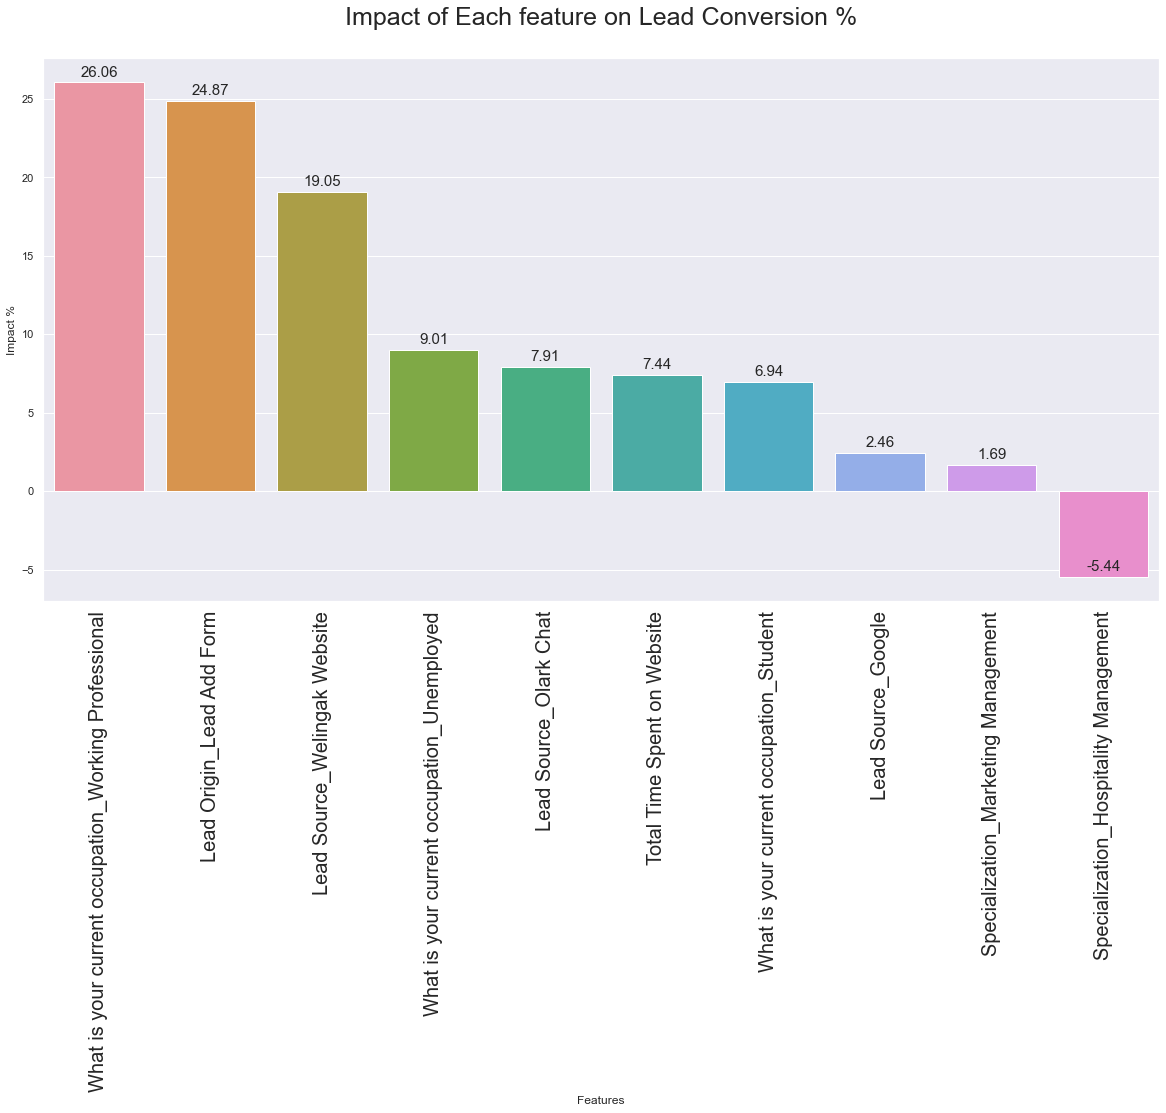

In [149]:
figure(20,10)
gplot = sns.barplot(x=Summary_DataFrame.Features,y=Summary_DataFrame['Impact %'])
for p in gplot.patches:
        gplot.annotate(p.get_height(),#text that you want to write on top
        (p.get_x() + p.get_width() / 2., p.get_height()),# coordinates where text should be there
        ha = 'center', va = 'center',size=15,# alignment of the text
        xytext = (0, 10),# distance of text from top of the patch
        textcoords = 'offset points'), #do not change and remove it
           
plt.xticks(size =20,rotation=90)
plt.title('Impact of Each feature on Lead Conversion %\n', fontdict={'size':25})
plt.show()

## Conclusions:

   1. Leads from __"Working Professionals"__ & __"Student"__ occupation are the ones which will have higher lead conversion probability of __33% Lead conversion chance__ compared to other occupations.
   2. Leads that have filled the __"Add Form"__ are the prospects that needs to be focused more comparatively for higher conversion rate - Approximately __25% Conversion rate__
   3. Leads coming from the background Specialization of __"Hospitality Management"__ will negatively impact the lead conversion rate __(-5.4%)__. Although the leads from "Marketing Management" also has less chances of being converted into a "Hot" lead.
   4. Considering the Lead_source we can infer that leads coming from __Welingak Website & Olark Chat__ has higher chances of getting converted __(27% Chance)__ compared to Google. 
   5. __"Time Spent on Website"__ is positively contributing towards the lead conversion with __7.4% Conversion rate__.
   

## Recommendations:

1. Leads coming from the source __"Welingak Website"__, Filling the __"Add Form"__ & belonging to __"Working Professional"__ occupation , has __"spent more time on website"__ & is coming from __"Marketing Management"__ background have __86%__ Conversion rate making them a "Hot" lead. That would help CEO to take unanimous decisions.

2. Leads coming from the source __"Google"__ and are belonging to Hospitality Management shall be ignored or less prioritized as they have very low conversion chances __(-3%)__.